In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
import torch.nn.init as I

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import nibabel

from PIL import ImageEnhance
from skimage import data, exposure, img_as_float
from skimage.filters import gaussian

In [2]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [3]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [4]:
# rest_available = [11,12,50,51]
rest_available = [ 2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [5]:
p = "/gpfs/data/cbi/hcp/hcp_seg/data_manual_extract/train/1000_3/Data_orig/image100.mat"

In [6]:
i = sio.loadmat(p)['img']

In [7]:
i.shape

(1, 256, 287)

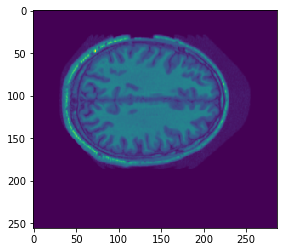

In [8]:
plt.imshow(i[0])

In [9]:
# import dipy
# import matplotlib.pylab as plt

# from dipy.data import get_data
# from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
# from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
# import dipy.align.imwarp as imwarp
# from dipy.viz import regtools

In [10]:
# metric = SSDMetric(2)
# level_iters = [200, 100, 50, 25]
# sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)

In [11]:


# m1 = x[88].reshape([256,256])
# m2 = x[94].reshape([256,256])

# plt.imshow(m1); plt.colorbar(); plt.show()
# plt.imshow(m2); plt.colorbar(); plt.show()

# regtools.overlay_images(m1, m2, 'channel1', 'channel2', 'both channels', 'tmp.png');
# metric = SSDMetric(2)
# level_iters = [200, 100, 50, 25]
# sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)

# mapping = sdr.optimize(m1, m2)

# regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')
# warped_m2 = mapping.transform(m2, 'linear')

# regtools.overlay_images(m1, warped_m2, 'initial m1','Overlay','Warped m2', 'direct_warp_result.png')
# plt.imshow(warped_m2); plt.colorbar(); plt.show()

# plt.imshow(m1-warped_m2); plt.colorbar(); plt.show()
# plt.imshow(m1-m2); plt.colorbar(); plt.show()

In [5]:
num_seg = len(rest_available)+1

In [6]:
x_coordinate = np.zeros((256,256))
for i in range(256):
    x_coordinate[i:] = [i]*256    
y_coordinate = x_coordinate.copy()
y_coordinate = y_coordinate.T

In [7]:
x_coordinate = x_coordinate/255
y_coordinate = y_coordinate/255

In [8]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True, \
                 coord = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data
        self.coord = coord

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = "/gpfs/data/"+self.image_dir[idx]
        aseg_path = "/gpfs/data/"+self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-10,10)
        dx = np.round(random.uniform(-25,25))
        dy = np.round(random.uniform(-25,25))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
#        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))/255
        guassian_flag = random.random() > 0.5
        
        im = np.array(im, np.float64, copy=False)
        min_im = np.min(im)
        max_im = np.max(im)
        im = (im - min_im)/(max_im - min_im + 1e-4)
        if self.train_data and guassian_flag:
            sigma_rand = random.uniform(0.65,1.0)
            im_sigma = gaussian(im, sigma = sigma_rand)
            gamma_rand = random.uniform(1.6,2.4)
            im_sigma_gamma = exposure.adjust_gamma(im_sigma, gamma_rand)
            im = (im_sigma_gamma - np.min(im_sigma_gamma))/(np.max(im_sigma_gamma)-np.min(im_sigma_gamma)+1e-4)
        
        
        if self.coord:
            im = np.array([im, x_coordinate, y_coordinate], np.float64, copy=False)
            im = torch.from_numpy(im).type(torch.FloatTensor)
        else:
            im = torch.from_numpy(im).type(torch.FloatTensor).unsqueeze(0)

        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((len(rest_available)+1,256,256))
        for i,a in enumerate(available_segments):
            temp = (target==a).astype(int)
            if a in rest_available:
                target_label[rest_available.index(a),:,:] = temp
            else:
                target_label[len(rest_available),:,:] = target_label[len(rest_available),:,:] + temp
        target_label[len(rest_available),:,:] = (target_label[len(rest_available),:,:]>=1).astype(int) 
#        print(target_label.shape)
        target_label = torch.from_numpy(target_label).type(torch.FloatTensor)
        sample = {'x':im,'y':target_label} 
        return sample

In [9]:
file_names = pd.read_csv("all_complete_path.csv")

In [10]:
train_subjects = unpickling("train_subject_index")
val_subjects = unpickling("val_subject_index")
test_subjects = unpickling("test_subject_index")

In [11]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [12]:
277*18

4986

In [13]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:5000]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:1000]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [14]:
cd = False
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False, coord = cd),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2], coord = cd),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3], coord = cd)
                                               }
bs = 12
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [15]:
data = next(iter(dataloader['train']))

In [16]:
data['y'].size()

torch.Size([12, 46, 256, 256])

In [17]:
data['x'].size()

torch.Size([12, 1, 256, 256])

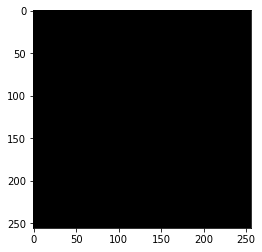

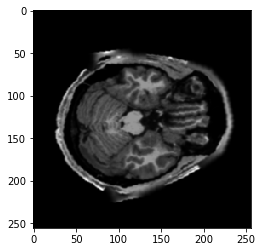

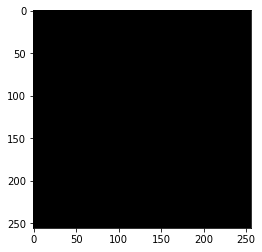

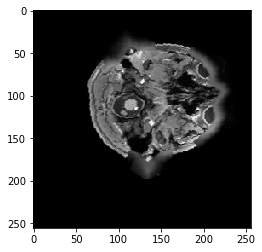

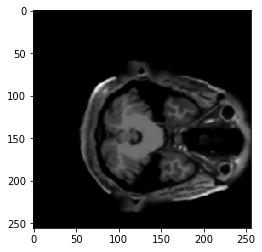

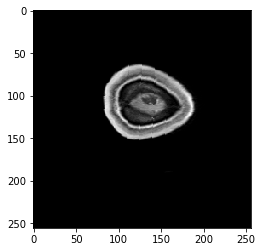

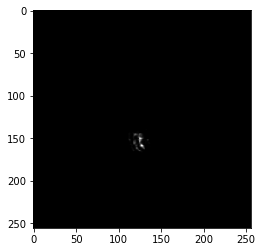

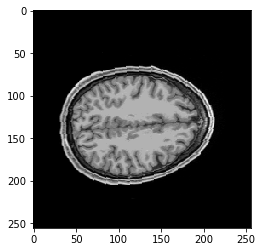

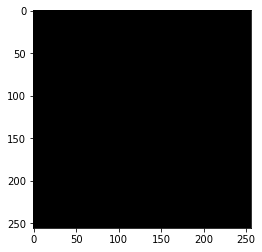

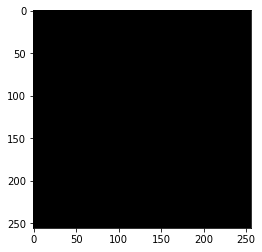

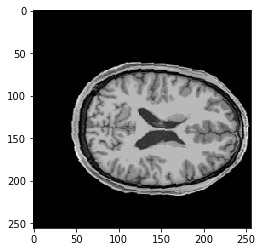

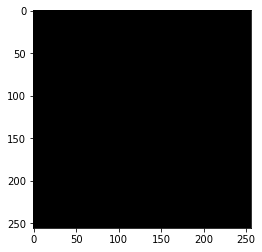

In [42]:
for i in range(bs):
    plt.imshow(data['x'][i,0,:,:],cmap='gray')
    plt.show()

In [25]:
# list_arr = []
# for data in dataloader["train"]:
#     y = data['y'].numpy()
#     N,C,_,_ = y.shape
#     sum_arr = np.sum(y.reshape(N,C,-1),axis = 2)
#     list_arr.append(sum_arr)
# final_arr = np.concatenate(list_arr,axis = 0)
# freq_class = np.true_divide(final_arr.sum(0),(final_arr!=0).sum(0)*(256*256))
# class_wts = np.median(freq_class)/freq_class
# pickling(class_wts,'new_class_wts_46_seg')

In [18]:
class_wts = unpickling('new_class_wts_46_seg')

In [19]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [20]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [21]:
class Unet(nn.Module):
    def __init__(self,in_chan = 3, out_chan = 3):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(in_chan,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,out_chan, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [22]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        I.xavier_normal(m.weight.data)

In [23]:
wts_torch = Variable(torch.from_numpy(class_wts)).cuda()

In [24]:
def get_gradient(true):
    true = true.data.cpu().numpy()
    N,C,sh1,sh2 = true.shape
    grads = []
    for i in range(N):
        grad_chan = []
        for j in range(C):
            sx = ndimage.sobel(true_out[i,j],axis=0,mode='constant')
            sy = ndimage.sobel(true_out[i,j],axis=1,mode='constant')
            sobel=np.hypot(sx,sy)
            grad_chan.append(sobel)
        grad_chan = np.vstack(grad_chan)
        grads.append(grad_chan)
    grads = np.vstack(grads)
    grads_mask = torch.from_numpy((np.absolute(grads)>0)).type(torch.cuda.FloatTensor)
    
    return grads_mask.view(N,C,-1)

In [25]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 2,we = 0.05):
#     N, C, sh1, sh2 = true1.size()
    
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return -1
    
    
    
    N, C, sh1, sh2 = true.size()
#     grad_mask = get_gradient(true)
#     grad_mask = grad_mask.view(N,C,-1)
    
    preds = F.softmax(scores, dim = 1)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
#     mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
#     wts = wts/(torch.sum(wts,dim = 1)[:,None])
#     print(wts)
    grad_wts = torch.max(mean)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    cel = -torch.sum(wts * torch.sum(true*torch.log(preds),dim = 2),dim = 1)
#     grad_loss = -torch.sum(2*grad_wts * torch.sum(grad_mask*torch.log(preds),dim = 2),dim = 1)
    return torch.mean(cel)
#     return torch.mean(loss)

In [26]:
def dice_score(true,scores, epsilon = 1e-7):
#     N ,C, sh1, sh2 = true1.size()
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return 0
    
    N, C, sh1, sh2 = true.size()
    
    true = true.view(N,C,-1)
    preds = F.softmax(scores, dim = 1)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*C
    for i in range(C):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*C
    for i in range(C):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
    return dice_class_score
    

In [27]:
import time
def train_model(model, optimizer,dataloader, name,num_seg = 3, num_epochs = 100, verbose = False, every = 1,\
                print_all_ds = True):
    since = time.time()
    best_loss = np.inf
    best_score = 0
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(num_seg)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*num_seg
            running_total = 0
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).cuda()
                y = Variable(y).cuda()
                N, C, sh1, sh2 = y.size()
                rand_num = np.random.rand()
                if rand_num < 0.90:
                    y_mask = (torch.sum(y[:,:(C-1),:,:].contiguous().view(N,-1),dim = 1) != 0)
                    y = y[y_mask]
                    x = x[y_mask]
#                 for sel in range(x.size()[0]):
#                     if torch.sum(y[sel,0,:,:]) != 0:
#                         y_sel.append(y[sel,:,:,:])
#                         x_sel.append(x[sel,:,:,:])

#                 try:
#                     y_sel = torch.stack(y_sel)
#                     output_sel = torch.stack(output_sel)
#                 except:
#                     continue
#                 output = model(x)
                try:
                    output = model(x)
                except:
                    continue
                loss = dice_loss_2(y, output,wts_torch)
                #loss = Variable(dice_loss_2(y_sel, output_sel,wts_torch),requires_grad=True)
                if loss==-1:
                    continue
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * N
                running_total += N
                dice_score_batch = dice_score(y,output)

                for j in range(num_seg):
                    run_class_scores[j] += dice_score_batch[j] * N
            epoch_loss = running_loss/running_total
            loss_hist[phase].append(epoch_loss.item())
            epoch_score = 0
            for j in range(num_seg):
                score = run_class_scores[j]/running_total
                dice_scores_of_all_class[j][phase].append(score.item())
                if j < num_seg - 1:
                    epoch_score += score.item()
            epoch_score_av = epoch_score/ (num_seg - 1)
            if verbose or i%every == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}, Av. Dice Score: {:.4f}'\
                      .format(i,phase,epoch_loss,epoch_score_av))
#                 epoch_score = 0
                if print_all_ds:
                    for j in range(num_seg - 1):
                        print('Class {} (DS): {:.4f}'.format(j,dice_scores_of_all_class[j][phase][-1]))
    #                 epoch_score += dice_scores_of_all_class[j][phase][-1]
    #             epoch_score_av = epoch_score / (num_seg - 1)
                print('-'*10)
            
        if phase == 'validate' and epoch_score_av > best_score:
            best_loss = epoch_loss
            best_score = epoch_score_av
            best_model_wts = model.state_dict()
            torch.save(model,name)
        #print(i)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}, Best Average DS: {:4f}'.format(best_loss,best_score))
    
    model.load_state_dict(best_model_wts)
    pickling(loss_hist,name+'loss_hist')
    pickling(dice_scores_of_all_class,name+'dice_hist')
    
    return model, loss_hist, dice_scores_of_all_class

In [28]:
model = Unet(in_chan = 1,out_chan = num_seg).cuda()
model.apply(weights_init)
model = nn.DataParallel(model)
criterion = dice_loss_2
#scheduler = lr_scheduler.StepLR(optimizer,step_size = 15)

In [31]:
optimizer = optim.Adam(model.parameters(),lr = 1e-4)

In [32]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_1_only_cel_loss_lr_1e-4',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 2190.2935, Av. Dice Score: 0.1651
Class 0 (DS): 0.4541
Class 1 (DS): 0.4516
Class 2 (DS): 0.2398
Class 3 (DS): 0.0489
Class 4 (DS): 0.3226
Class 5 (DS): 0.1690
Class 6 (DS): 0.0930
Class 7 (DS): 0.1685
Class 8 (DS): 0.0780
Class 9 (DS): 0.1013
Class 10 (DS): 0.0036
Class 11 (DS): 0.1743
Class 12 (DS): 0.1978
Class 13 (DS): 0.2805
Class 14 (DS): 0.0270
Class 15 (DS): 0.1495
Class 16 (DS): 0.0081
Class 17 (DS): 0.0556
Class 18 (DS): 0.3009
Class 19 (DS): 0.0775
Class 20 (DS): 0.4933
Class 21 (DS): 0.4135
Class 22 (DS): 0.1385
Class 23 (DS): 0.3594
Class 24 (DS): 0.2280
Class 25 (DS): 0.2027
Class 26 (DS): 0.0616
Class 27 (DS): 0.0975
Class 28 (DS): 0.0852
Class 29 (DS): 0.1127
Class 30 (DS): 0.0067
Class 31 (DS): 0.3410
Class 32 (DS): 0.2837
Class 33 (DS): 0.0600
Class 34 (DS): 0.0480
Class 35 (DS): 0.0308
Class 36 (DS): 0.0000
Class 37 (DS): 0.0570
Class 38 (DS): 0.0574
Class 39 (DS): 0.0314
Class 40 (DS): 0.0457
Class 41 (DS): 0.0800
Class 42 (DS): 0

Epoch: 4, Phase: validate, epoch loss: 374.5563, Av. Dice Score: 0.8655
Class 0 (DS): 0.7881
Class 1 (DS): 0.7494
Class 2 (DS): 0.9122
Class 3 (DS): 0.9132
Class 4 (DS): 0.8482
Class 5 (DS): 0.8482
Class 6 (DS): 0.9418
Class 7 (DS): 0.9307
Class 8 (DS): 0.9265
Class 9 (DS): 0.9186
Class 10 (DS): 0.8267
Class 11 (DS): 0.6986
Class 12 (DS): 0.8991
Class 13 (DS): 0.8900
Class 14 (DS): 0.9442
Class 15 (DS): 0.8561
Class 16 (DS): 0.9230
Class 17 (DS): 0.9050
Class 18 (DS): 0.9292
Class 19 (DS): 0.7852
Class 20 (DS): 0.7264
Class 21 (DS): 0.6994
Class 22 (DS): 0.8583
Class 23 (DS): 0.9225
Class 24 (DS): 0.8584
Class 25 (DS): 0.8377
Class 26 (DS): 0.9495
Class 27 (DS): 0.9353
Class 28 (DS): 0.9036
Class 29 (DS): 0.8945
Class 30 (DS): 0.8941
Class 31 (DS): 0.9323
Class 32 (DS): 0.8637
Class 33 (DS): 0.8826
Class 34 (DS): 0.8949
Class 35 (DS): 0.7682
Class 36 (DS): 0.9301
Class 37 (DS): 0.6661
Class 38 (DS): 0.7977
Class 39 (DS): 0.9344
Class 40 (DS): 0.8605
Class 41 (DS): 0.8894
Class 42 (DS):

Epoch: 8, Phase: validate, epoch loss: 256.1633, Av. Dice Score: 0.8916
Class 0 (DS): 0.8602
Class 1 (DS): 0.7670
Class 2 (DS): 0.9409
Class 3 (DS): 0.8618
Class 4 (DS): 0.8944
Class 5 (DS): 0.8745
Class 6 (DS): 0.9597
Class 7 (DS): 0.9507
Class 8 (DS): 0.9072
Class 9 (DS): 0.8978
Class 10 (DS): 0.8819
Class 11 (DS): 0.7232
Class 12 (DS): 0.9045
Class 13 (DS): 0.9053
Class 14 (DS): 0.9431
Class 15 (DS): 0.8654
Class 16 (DS): 0.9337
Class 17 (DS): 0.9247
Class 18 (DS): 0.9393
Class 19 (DS): 0.7948
Class 20 (DS): 0.8495
Class 21 (DS): 0.7673
Class 22 (DS): 0.9049
Class 23 (DS): 0.9253
Class 24 (DS): 0.8882
Class 25 (DS): 0.8922
Class 26 (DS): 0.9640
Class 27 (DS): 0.9466
Class 28 (DS): 0.9462
Class 29 (DS): 0.9482
Class 30 (DS): 0.9125
Class 31 (DS): 0.9438
Class 32 (DS): 0.8852
Class 33 (DS): 0.9156
Class 34 (DS): 0.9563
Class 35 (DS): 0.7742
Class 36 (DS): 0.9490
Class 37 (DS): 0.6683
Class 38 (DS): 0.8536
Class 39 (DS): 0.9379
Class 40 (DS): 0.9390
Class 41 (DS): 0.9494
Class 42 (DS):

Epoch: 12, Phase: validate, epoch loss: 261.9015, Av. Dice Score: 0.8959
Class 0 (DS): 0.8639
Class 1 (DS): 0.7833
Class 2 (DS): 0.9364
Class 3 (DS): 0.8207
Class 4 (DS): 0.8864
Class 5 (DS): 0.8761
Class 6 (DS): 0.9555
Class 7 (DS): 0.9504
Class 8 (DS): 0.9415
Class 9 (DS): 0.9222
Class 10 (DS): 0.8733
Class 11 (DS): 0.7631
Class 12 (DS): 0.9150
Class 13 (DS): 0.9282
Class 14 (DS): 0.9605
Class 15 (DS): 0.8518
Class 16 (DS): 0.9470
Class 17 (DS): 0.9345
Class 18 (DS): 0.9559
Class 19 (DS): 0.8219
Class 20 (DS): 0.8531
Class 21 (DS): 0.7754
Class 22 (DS): 0.9404
Class 23 (DS): 0.9427
Class 24 (DS): 0.9043
Class 25 (DS): 0.8861
Class 26 (DS): 0.9608
Class 27 (DS): 0.9467
Class 28 (DS): 0.9542
Class 29 (DS): 0.9327
Class 30 (DS): 0.9249
Class 31 (DS): 0.9544
Class 32 (DS): 0.9089
Class 33 (DS): 0.9269
Class 34 (DS): 0.9600
Class 35 (DS): 0.7963
Class 36 (DS): 0.9198
Class 37 (DS): 0.6404
Class 38 (DS): 0.8426
Class 39 (DS): 0.9318
Class 40 (DS): 0.9511
Class 41 (DS): 0.9562
Class 42 (DS)

Epoch: 16, Phase: validate, epoch loss: 254.5973, Av. Dice Score: 0.8976
Class 0 (DS): 0.8594
Class 1 (DS): 0.7776
Class 2 (DS): 0.9495
Class 3 (DS): 0.8781
Class 4 (DS): 0.8473
Class 5 (DS): 0.8617
Class 6 (DS): 0.9568
Class 7 (DS): 0.9570
Class 8 (DS): 0.9277
Class 9 (DS): 0.9068
Class 10 (DS): 0.9126
Class 11 (DS): 0.8217
Class 12 (DS): 0.9096
Class 13 (DS): 0.9144
Class 14 (DS): 0.9607
Class 15 (DS): 0.8896
Class 16 (DS): 0.9475
Class 17 (DS): 0.9306
Class 18 (DS): 0.9601
Class 19 (DS): 0.8085
Class 20 (DS): 0.8192
Class 21 (DS): 0.7694
Class 22 (DS): 0.8895
Class 23 (DS): 0.9412
Class 24 (DS): 0.8919
Class 25 (DS): 0.8998
Class 26 (DS): 0.9585
Class 27 (DS): 0.9528
Class 28 (DS): 0.9454
Class 29 (DS): 0.9449
Class 30 (DS): 0.9129
Class 31 (DS): 0.9428
Class 32 (DS): 0.9216
Class 33 (DS): 0.9238
Class 34 (DS): 0.9563
Class 35 (DS): 0.8034
Class 36 (DS): 0.9550
Class 37 (DS): 0.7091
Class 38 (DS): 0.8292
Class 39 (DS): 0.9402
Class 40 (DS): 0.9302
Class 41 (DS): 0.9412
Class 42 (DS)

Epoch: 20, Phase: validate, epoch loss: 225.3172, Av. Dice Score: 0.9037
Class 0 (DS): 0.7793
Class 1 (DS): 0.7517
Class 2 (DS): 0.9428
Class 3 (DS): 0.9371
Class 4 (DS): 0.9065
Class 5 (DS): 0.8887
Class 6 (DS): 0.9575
Class 7 (DS): 0.9620
Class 8 (DS): 0.9579
Class 9 (DS): 0.9297
Class 10 (DS): 0.8745
Class 11 (DS): 0.8557
Class 12 (DS): 0.9171
Class 13 (DS): 0.9235
Class 14 (DS): 0.9568
Class 15 (DS): 0.8713
Class 16 (DS): 0.9519
Class 17 (DS): 0.9278
Class 18 (DS): 0.9588
Class 19 (DS): 0.8394
Class 20 (DS): 0.8525
Class 21 (DS): 0.7928
Class 22 (DS): 0.9327
Class 23 (DS): 0.9531
Class 24 (DS): 0.8995
Class 25 (DS): 0.8818
Class 26 (DS): 0.9631
Class 27 (DS): 0.9568
Class 28 (DS): 0.9629
Class 29 (DS): 0.9534
Class 30 (DS): 0.9008
Class 31 (DS): 0.9547
Class 32 (DS): 0.9119
Class 33 (DS): 0.9145
Class 34 (DS): 0.9361
Class 35 (DS): 0.8074
Class 36 (DS): 0.9528
Class 37 (DS): 0.7061
Class 38 (DS): 0.8209
Class 39 (DS): 0.9499
Class 40 (DS): 0.9510
Class 41 (DS): 0.9444
Class 42 (DS)

Epoch: 24, Phase: validate, epoch loss: 239.8060, Av. Dice Score: 0.9029
Class 0 (DS): 0.8301
Class 1 (DS): 0.7538
Class 2 (DS): 0.9443
Class 3 (DS): 0.8684
Class 4 (DS): 0.8990
Class 5 (DS): 0.9037
Class 6 (DS): 0.9645
Class 7 (DS): 0.9575
Class 8 (DS): 0.9398
Class 9 (DS): 0.9237
Class 10 (DS): 0.8974
Class 11 (DS): 0.8261
Class 12 (DS): 0.9172
Class 13 (DS): 0.9119
Class 14 (DS): 0.9399
Class 15 (DS): 0.8946
Class 16 (DS): 0.9434
Class 17 (DS): 0.9322
Class 18 (DS): 0.9597
Class 19 (DS): 0.8368
Class 20 (DS): 0.8816
Class 21 (DS): 0.8321
Class 22 (DS): 0.9478
Class 23 (DS): 0.9277
Class 24 (DS): 0.9111
Class 25 (DS): 0.9068
Class 26 (DS): 0.9639
Class 27 (DS): 0.9567
Class 28 (DS): 0.9265
Class 29 (DS): 0.9365
Class 30 (DS): 0.9136
Class 31 (DS): 0.9539
Class 32 (DS): 0.9140
Class 33 (DS): 0.9296
Class 34 (DS): 0.9587
Class 35 (DS): 0.8099
Class 36 (DS): 0.9265
Class 37 (DS): 0.6280
Class 38 (DS): 0.8574
Class 39 (DS): 0.9404
Class 40 (DS): 0.9491
Class 41 (DS): 0.9622
Class 42 (DS)

Epoch: 28, Phase: validate, epoch loss: 230.4867, Av. Dice Score: 0.9136
Class 0 (DS): 0.8934
Class 1 (DS): 0.7860
Class 2 (DS): 0.9612
Class 3 (DS): 0.9494
Class 4 (DS): 0.8996
Class 5 (DS): 0.8902
Class 6 (DS): 0.9607
Class 7 (DS): 0.9663
Class 8 (DS): 0.9498
Class 9 (DS): 0.9351
Class 10 (DS): 0.9291
Class 11 (DS): 0.8293
Class 12 (DS): 0.9210
Class 13 (DS): 0.9228
Class 14 (DS): 0.9693
Class 15 (DS): 0.9205
Class 16 (DS): 0.9475
Class 17 (DS): 0.9366
Class 18 (DS): 0.9684
Class 19 (DS): 0.8485
Class 20 (DS): 0.8964
Class 21 (DS): 0.8125
Class 22 (DS): 0.9472
Class 23 (DS): 0.9380
Class 24 (DS): 0.9053
Class 25 (DS): 0.8540
Class 26 (DS): 0.9691
Class 27 (DS): 0.9672
Class 28 (DS): 0.9457
Class 29 (DS): 0.9418
Class 30 (DS): 0.9305
Class 31 (DS): 0.9593
Class 32 (DS): 0.9445
Class 33 (DS): 0.9263
Class 34 (DS): 0.9558
Class 35 (DS): 0.8119
Class 36 (DS): 0.9394
Class 37 (DS): 0.6866
Class 38 (DS): 0.8541
Class 39 (DS): 0.9500
Class 40 (DS): 0.9646
Class 41 (DS): 0.9596
Class 42 (DS)

In [33]:
optimizer = optim.Adam(model.parameters(),lr = 5e-5)

In [34]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_2_only_cel_loss_lr_5e-5',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 162.8500, Av. Dice Score: 0.9175
Class 0 (DS): 0.8805
Class 1 (DS): 0.7965
Class 2 (DS): 0.9582
Class 3 (DS): 0.9369
Class 4 (DS): 0.8997
Class 5 (DS): 0.8869
Class 6 (DS): 0.9634
Class 7 (DS): 0.9591
Class 8 (DS): 0.9544
Class 9 (DS): 0.9412
Class 10 (DS): 0.9325
Class 11 (DS): 0.8348
Class 12 (DS): 0.9136
Class 13 (DS): 0.9336
Class 14 (DS): 0.9568
Class 15 (DS): 0.9263
Class 16 (DS): 0.9530
Class 17 (DS): 0.9397
Class 18 (DS): 0.9722
Class 19 (DS): 0.8439
Class 20 (DS): 0.8733
Class 21 (DS): 0.8012
Class 22 (DS): 0.9537
Class 23 (DS): 0.9505
Class 24 (DS): 0.9047
Class 25 (DS): 0.8841
Class 26 (DS): 0.9656
Class 27 (DS): 0.9571
Class 28 (DS): 0.9525
Class 29 (DS): 0.9507
Class 30 (DS): 0.9331
Class 31 (DS): 0.9511
Class 32 (DS): 0.9458
Class 33 (DS): 0.9366
Class 34 (DS): 0.9713
Class 35 (DS): 0.8396
Class 36 (DS): 0.9646
Class 37 (DS): 0.7007
Class 38 (DS): 0.8774
Class 39 (DS): 0.9464
Class 40 (DS): 0.9603
Class 41 (DS): 0.9591
Class 42 (DS): 0.

Epoch: 4, Phase: train, epoch loss: 155.9736, Av. Dice Score: 0.9207
Class 0 (DS): 0.8847
Class 1 (DS): 0.8038
Class 2 (DS): 0.9572
Class 3 (DS): 0.9408
Class 4 (DS): 0.9049
Class 5 (DS): 0.8880
Class 6 (DS): 0.9630
Class 7 (DS): 0.9570
Class 8 (DS): 0.9535
Class 9 (DS): 0.9402
Class 10 (DS): 0.9376
Class 11 (DS): 0.8399
Class 12 (DS): 0.9126
Class 13 (DS): 0.9369
Class 14 (DS): 0.9602
Class 15 (DS): 0.9286
Class 16 (DS): 0.9511
Class 17 (DS): 0.9440
Class 18 (DS): 0.9667
Class 19 (DS): 0.8480
Class 20 (DS): 0.8881
Class 21 (DS): 0.8162
Class 22 (DS): 0.9624
Class 23 (DS): 0.9593
Class 24 (DS): 0.9012
Class 25 (DS): 0.8865
Class 26 (DS): 0.9641
Class 27 (DS): 0.9572
Class 28 (DS): 0.9536
Class 29 (DS): 0.9462
Class 30 (DS): 0.9334
Class 31 (DS): 0.9569
Class 32 (DS): 0.9440
Class 33 (DS): 0.9425
Class 34 (DS): 0.9723
Class 35 (DS): 0.8420
Class 36 (DS): 0.9673
Class 37 (DS): 0.7281
Class 38 (DS): 0.8782
Class 39 (DS): 0.9509
Class 40 (DS): 0.9641
Class 41 (DS): 0.9618
Class 42 (DS): 0.

Epoch: 8, Phase: train, epoch loss: 148.9120, Av. Dice Score: 0.9221
Class 0 (DS): 0.8905
Class 1 (DS): 0.8106
Class 2 (DS): 0.9535
Class 3 (DS): 0.9433
Class 4 (DS): 0.9053
Class 5 (DS): 0.8918
Class 6 (DS): 0.9630
Class 7 (DS): 0.9565
Class 8 (DS): 0.9554
Class 9 (DS): 0.9422
Class 10 (DS): 0.9368
Class 11 (DS): 0.8453
Class 12 (DS): 0.9117
Class 13 (DS): 0.9360
Class 14 (DS): 0.9638
Class 15 (DS): 0.9301
Class 16 (DS): 0.9509
Class 17 (DS): 0.9401
Class 18 (DS): 0.9699
Class 19 (DS): 0.8470
Class 20 (DS): 0.8918
Class 21 (DS): 0.8294
Class 22 (DS): 0.9588
Class 23 (DS): 0.9587
Class 24 (DS): 0.9038
Class 25 (DS): 0.8879
Class 26 (DS): 0.9634
Class 27 (DS): 0.9583
Class 28 (DS): 0.9555
Class 29 (DS): 0.9535
Class 30 (DS): 0.9320
Class 31 (DS): 0.9564
Class 32 (DS): 0.9419
Class 33 (DS): 0.9339
Class 34 (DS): 0.9724
Class 35 (DS): 0.8452
Class 36 (DS): 0.9694
Class 37 (DS): 0.7353
Class 38 (DS): 0.8852
Class 39 (DS): 0.9494
Class 40 (DS): 0.9648
Class 41 (DS): 0.9637
Class 42 (DS): 0.

Epoch: 12, Phase: train, epoch loss: 144.7027, Av. Dice Score: 0.9234
Class 0 (DS): 0.8858
Class 1 (DS): 0.8024
Class 2 (DS): 0.9578
Class 3 (DS): 0.9474
Class 4 (DS): 0.9016
Class 5 (DS): 0.8810
Class 6 (DS): 0.9647
Class 7 (DS): 0.9578
Class 8 (DS): 0.9558
Class 9 (DS): 0.9442
Class 10 (DS): 0.9358
Class 11 (DS): 0.8440
Class 12 (DS): 0.9172
Class 13 (DS): 0.9406
Class 14 (DS): 0.9628
Class 15 (DS): 0.9394
Class 16 (DS): 0.9560
Class 17 (DS): 0.9488
Class 18 (DS): 0.9717
Class 19 (DS): 0.8565
Class 20 (DS): 0.8961
Class 21 (DS): 0.8236
Class 22 (DS): 0.9588
Class 23 (DS): 0.9565
Class 24 (DS): 0.9073
Class 25 (DS): 0.8822
Class 26 (DS): 0.9658
Class 27 (DS): 0.9575
Class 28 (DS): 0.9564
Class 29 (DS): 0.9488
Class 30 (DS): 0.9312
Class 31 (DS): 0.9563
Class 32 (DS): 0.9510
Class 33 (DS): 0.9423
Class 34 (DS): 0.9740
Class 35 (DS): 0.8479
Class 36 (DS): 0.9715
Class 37 (DS): 0.7482
Class 38 (DS): 0.8838
Class 39 (DS): 0.9513
Class 40 (DS): 0.9669
Class 41 (DS): 0.9644
Class 42 (DS): 0

Epoch: 16, Phase: train, epoch loss: 139.8476, Av. Dice Score: 0.9257
Class 0 (DS): 0.9012
Class 1 (DS): 0.8121
Class 2 (DS): 0.9633
Class 3 (DS): 0.9484
Class 4 (DS): 0.9084
Class 5 (DS): 0.8858
Class 6 (DS): 0.9662
Class 7 (DS): 0.9596
Class 8 (DS): 0.9570
Class 9 (DS): 0.9467
Class 10 (DS): 0.9400
Class 11 (DS): 0.8459
Class 12 (DS): 0.9160
Class 13 (DS): 0.9400
Class 14 (DS): 0.9644
Class 15 (DS): 0.9379
Class 16 (DS): 0.9546
Class 17 (DS): 0.9479
Class 18 (DS): 0.9766
Class 19 (DS): 0.8588
Class 20 (DS): 0.9005
Class 21 (DS): 0.8223
Class 22 (DS): 0.9584
Class 23 (DS): 0.9604
Class 24 (DS): 0.9158
Class 25 (DS): 0.8868
Class 26 (DS): 0.9677
Class 27 (DS): 0.9590
Class 28 (DS): 0.9575
Class 29 (DS): 0.9524
Class 30 (DS): 0.9359
Class 31 (DS): 0.9577
Class 32 (DS): 0.9491
Class 33 (DS): 0.9414
Class 34 (DS): 0.9728
Class 35 (DS): 0.8479
Class 36 (DS): 0.9668
Class 37 (DS): 0.7463
Class 38 (DS): 0.8957
Class 39 (DS): 0.9530
Class 40 (DS): 0.9654
Class 41 (DS): 0.9631
Class 42 (DS): 0

Epoch: 20, Phase: train, epoch loss: 137.7112, Av. Dice Score: 0.9269
Class 0 (DS): 0.8890
Class 1 (DS): 0.8106
Class 2 (DS): 0.9648
Class 3 (DS): 0.9498
Class 4 (DS): 0.9076
Class 5 (DS): 0.8917
Class 6 (DS): 0.9675
Class 7 (DS): 0.9620
Class 8 (DS): 0.9587
Class 9 (DS): 0.9450
Class 10 (DS): 0.9414
Class 11 (DS): 0.8490
Class 12 (DS): 0.9166
Class 13 (DS): 0.9389
Class 14 (DS): 0.9635
Class 15 (DS): 0.9369
Class 16 (DS): 0.9554
Class 17 (DS): 0.9528
Class 18 (DS): 0.9731
Class 19 (DS): 0.8606
Class 20 (DS): 0.8980
Class 21 (DS): 0.8326
Class 22 (DS): 0.9586
Class 23 (DS): 0.9630
Class 24 (DS): 0.9155
Class 25 (DS): 0.8918
Class 26 (DS): 0.9661
Class 27 (DS): 0.9593
Class 28 (DS): 0.9587
Class 29 (DS): 0.9552
Class 30 (DS): 0.9321
Class 31 (DS): 0.9551
Class 32 (DS): 0.9507
Class 33 (DS): 0.9467
Class 34 (DS): 0.9773
Class 35 (DS): 0.8517
Class 36 (DS): 0.9728
Class 37 (DS): 0.7502
Class 38 (DS): 0.9022
Class 39 (DS): 0.9550
Class 40 (DS): 0.9656
Class 41 (DS): 0.9660
Class 42 (DS): 0

Epoch: 24, Phase: train, epoch loss: 131.7715, Av. Dice Score: 0.9282
Class 0 (DS): 0.8956
Class 1 (DS): 0.8137
Class 2 (DS): 0.9581
Class 3 (DS): 0.9541
Class 4 (DS): 0.9105
Class 5 (DS): 0.8936
Class 6 (DS): 0.9670
Class 7 (DS): 0.9615
Class 8 (DS): 0.9594
Class 9 (DS): 0.9479
Class 10 (DS): 0.9418
Class 11 (DS): 0.8595
Class 12 (DS): 0.9128
Class 13 (DS): 0.9381
Class 14 (DS): 0.9648
Class 15 (DS): 0.9376
Class 16 (DS): 0.9581
Class 17 (DS): 0.9465
Class 18 (DS): 0.9749
Class 19 (DS): 0.8649
Class 20 (DS): 0.8938
Class 21 (DS): 0.8342
Class 22 (DS): 0.9574
Class 23 (DS): 0.9645
Class 24 (DS): 0.9159
Class 25 (DS): 0.8930
Class 26 (DS): 0.9624
Class 27 (DS): 0.9616
Class 28 (DS): 0.9565
Class 29 (DS): 0.9515
Class 30 (DS): 0.9385
Class 31 (DS): 0.9587
Class 32 (DS): 0.9514
Class 33 (DS): 0.9447
Class 34 (DS): 0.9781
Class 35 (DS): 0.8561
Class 36 (DS): 0.9781
Class 37 (DS): 0.7571
Class 38 (DS): 0.9056
Class 39 (DS): 0.9562
Class 40 (DS): 0.9625
Class 41 (DS): 0.9655
Class 42 (DS): 0

Epoch: 28, Phase: train, epoch loss: 130.5402, Av. Dice Score: 0.9301
Class 0 (DS): 0.9057
Class 1 (DS): 0.8169
Class 2 (DS): 0.9590
Class 3 (DS): 0.9521
Class 4 (DS): 0.9116
Class 5 (DS): 0.8915
Class 6 (DS): 0.9691
Class 7 (DS): 0.9634
Class 8 (DS): 0.9599
Class 9 (DS): 0.9489
Class 10 (DS): 0.9470
Class 11 (DS): 0.8539
Class 12 (DS): 0.9188
Class 13 (DS): 0.9435
Class 14 (DS): 0.9647
Class 15 (DS): 0.9403
Class 16 (DS): 0.9611
Class 17 (DS): 0.9501
Class 18 (DS): 0.9773
Class 19 (DS): 0.8640
Class 20 (DS): 0.8998
Class 21 (DS): 0.8297
Class 22 (DS): 0.9553
Class 23 (DS): 0.9687
Class 24 (DS): 0.9213
Class 25 (DS): 0.8961
Class 26 (DS): 0.9684
Class 27 (DS): 0.9633
Class 28 (DS): 0.9604
Class 29 (DS): 0.9544
Class 30 (DS): 0.9386
Class 31 (DS): 0.9595
Class 32 (DS): 0.9524
Class 33 (DS): 0.9492
Class 34 (DS): 0.9750
Class 35 (DS): 0.8545
Class 36 (DS): 0.9748
Class 37 (DS): 0.7767
Class 38 (DS): 0.9193
Class 39 (DS): 0.9501
Class 40 (DS): 0.9648
Class 41 (DS): 0.9661
Class 42 (DS): 0

In [35]:
optimizer = optim.Adam(model.parameters(),lr = 1e-5)

In [36]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_3_only_cel_loss_lr_1e-5',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 118.9980, Av. Dice Score: 0.9352
Class 0 (DS): 0.9059
Class 1 (DS): 0.8292
Class 2 (DS): 0.9576
Class 3 (DS): 0.9591
Class 4 (DS): 0.9185
Class 5 (DS): 0.8965
Class 6 (DS): 0.9698
Class 7 (DS): 0.9654
Class 8 (DS): 0.9643
Class 9 (DS): 0.9523
Class 10 (DS): 0.9525
Class 11 (DS): 0.8666
Class 12 (DS): 0.9242
Class 13 (DS): 0.9468
Class 14 (DS): 0.9688
Class 15 (DS): 0.9429
Class 16 (DS): 0.9620
Class 17 (DS): 0.9524
Class 18 (DS): 0.9796
Class 19 (DS): 0.8720
Class 20 (DS): 0.9083
Class 21 (DS): 0.8392
Class 22 (DS): 0.9658
Class 23 (DS): 0.9673
Class 24 (DS): 0.9232
Class 25 (DS): 0.8976
Class 26 (DS): 0.9673
Class 27 (DS): 0.9630
Class 28 (DS): 0.9614
Class 29 (DS): 0.9543
Class 30 (DS): 0.9414
Class 31 (DS): 0.9623
Class 32 (DS): 0.9567
Class 33 (DS): 0.9507
Class 34 (DS): 0.9780
Class 35 (DS): 0.8666
Class 36 (DS): 0.9808
Class 37 (DS): 0.8015
Class 38 (DS): 0.9263
Class 39 (DS): 0.9564
Class 40 (DS): 0.9711
Class 41 (DS): 0.9720
Class 42 (DS): 0.

Epoch: 4, Phase: train, epoch loss: nan, Av. Dice Score: 0.8804
Class 0 (DS): 0.6846
Class 1 (DS): 0.6047
Class 2 (DS): 0.9013
Class 3 (DS): 0.9477
Class 4 (DS): 0.8503
Class 5 (DS): 0.7941
Class 6 (DS): 0.9158
Class 7 (DS): 0.8970
Class 8 (DS): 0.9124
Class 9 (DS): 0.9328
Class 10 (DS): 0.9159
Class 11 (DS): 0.8125
Class 12 (DS): 0.7916
Class 13 (DS): 0.8904
Class 14 (DS): 0.9431
Class 15 (DS): 0.9152
Class 16 (DS): 0.9406
Class 17 (DS): 0.9282
Class 18 (DS): 0.9773
Class 19 (DS): 0.8286
Class 20 (DS): 0.6738
Class 21 (DS): 0.6129
Class 22 (DS): 0.8996
Class 23 (DS): 0.9530
Class 24 (DS): 0.8557
Class 25 (DS): 0.7903
Class 26 (DS): 0.9191
Class 27 (DS): 0.8991
Class 28 (DS): 0.9103
Class 29 (DS): 0.9349
Class 30 (DS): 0.8881
Class 31 (DS): 0.9331
Class 32 (DS): 0.9398
Class 33 (DS): 0.9264
Class 34 (DS): 0.9742
Class 35 (DS): 0.8235
Class 36 (DS): 0.9817
Class 37 (DS): 0.7830
Class 38 (DS): 0.9433
Class 39 (DS): 0.9591
Class 40 (DS): 0.9370
Class 41 (DS): 0.9562
Class 42 (DS): 0.9160


Epoch: 8, Phase: train, epoch loss: nan, Av. Dice Score: 0.7724
Class 0 (DS): 0.2592
Class 1 (DS): 0.1888
Class 2 (DS): 0.7955
Class 3 (DS): 0.9096
Class 4 (DS): 0.6984
Class 5 (DS): 0.5776
Class 6 (DS): 0.8305
Class 7 (DS): 0.7814
Class 8 (DS): 0.8132
Class 9 (DS): 0.8894
Class 10 (DS): 0.8375
Class 11 (DS): 0.6920
Class 12 (DS): 0.5324
Class 13 (DS): 0.7643
Class 14 (DS): 0.8781
Class 15 (DS): 0.8731
Class 16 (DS): 0.8985
Class 17 (DS): 0.8633
Class 18 (DS): 0.9679
Class 19 (DS): 0.7408
Class 20 (DS): 0.2509
Class 21 (DS): 0.1862
Class 22 (DS): 0.7956
Class 23 (DS): 0.9153
Class 24 (DS): 0.7025
Class 25 (DS): 0.5704
Class 26 (DS): 0.8375
Class 27 (DS): 0.7905
Class 28 (DS): 0.8153
Class 29 (DS): 0.8982
Class 30 (DS): 0.7598
Class 31 (DS): 0.8713
Class 32 (DS): 0.9026
Class 33 (DS): 0.8591
Class 34 (DS): 0.9667
Class 35 (DS): 0.7325
Class 36 (DS): 0.9888
Class 37 (DS): 0.7511
Class 38 (DS): 0.9569
Class 39 (DS): 0.9525
Class 40 (DS): 0.8821
Class 41 (DS): 0.9299
Class 42 (DS): 0.9095


Epoch: 12, Phase: train, epoch loss: nan, Av. Dice Score: 0.7739
Class 0 (DS): 0.2542
Class 1 (DS): 0.1839
Class 2 (DS): 0.7989
Class 3 (DS): 0.9128
Class 4 (DS): 0.6991
Class 5 (DS): 0.5783
Class 6 (DS): 0.8331
Class 7 (DS): 0.7853
Class 8 (DS): 0.8178
Class 9 (DS): 0.8952
Class 10 (DS): 0.8422
Class 11 (DS): 0.6920
Class 12 (DS): 0.5304
Class 13 (DS): 0.7704
Class 14 (DS): 0.8785
Class 15 (DS): 0.8773
Class 16 (DS): 0.9034
Class 17 (DS): 0.8649
Class 18 (DS): 0.9704
Class 19 (DS): 0.7432
Class 20 (DS): 0.2483
Class 21 (DS): 0.1817
Class 22 (DS): 0.7990
Class 23 (DS): 0.9147
Class 24 (DS): 0.7038
Class 25 (DS): 0.5695
Class 26 (DS): 0.8407
Class 27 (DS): 0.7927
Class 28 (DS): 0.8190
Class 29 (DS): 0.9026
Class 30 (DS): 0.7649
Class 31 (DS): 0.8715
Class 32 (DS): 0.9048
Class 33 (DS): 0.8601
Class 34 (DS): 0.9670
Class 35 (DS): 0.7355
Class 36 (DS): 0.9882
Class 37 (DS): 0.7515
Class 38 (DS): 0.9585
Class 39 (DS): 0.9514
Class 40 (DS): 0.8824
Class 41 (DS): 0.9282
Class 42 (DS): 0.9087

Epoch: 16, Phase: train, epoch loss: nan, Av. Dice Score: 0.7732
Class 0 (DS): 0.2584
Class 1 (DS): 0.1893
Class 2 (DS): 0.7975
Class 3 (DS): 0.9098
Class 4 (DS): 0.6969
Class 5 (DS): 0.5781
Class 6 (DS): 0.8320
Class 7 (DS): 0.7816
Class 8 (DS): 0.8157
Class 9 (DS): 0.8930
Class 10 (DS): 0.8411
Class 11 (DS): 0.6916
Class 12 (DS): 0.5342
Class 13 (DS): 0.7668
Class 14 (DS): 0.8751
Class 15 (DS): 0.8761
Class 16 (DS): 0.9010
Class 17 (DS): 0.8637
Class 18 (DS): 0.9719
Class 19 (DS): 0.7422
Class 20 (DS): 0.2524
Class 21 (DS): 0.1861
Class 22 (DS): 0.7976
Class 23 (DS): 0.9132
Class 24 (DS): 0.7006
Class 25 (DS): 0.5702
Class 26 (DS): 0.8388
Class 27 (DS): 0.7894
Class 28 (DS): 0.8186
Class 29 (DS): 0.9012
Class 30 (DS): 0.7601
Class 31 (DS): 0.8701
Class 32 (DS): 0.9048
Class 33 (DS): 0.8593
Class 34 (DS): 0.9676
Class 35 (DS): 0.7358
Class 36 (DS): 0.9885
Class 37 (DS): 0.7538
Class 38 (DS): 0.9585
Class 39 (DS): 0.9512
Class 40 (DS): 0.8821
Class 41 (DS): 0.9279
Class 42 (DS): 0.9081

Epoch: 20, Phase: train, epoch loss: nan, Av. Dice Score: 0.7714
Class 0 (DS): 0.2537
Class 1 (DS): 0.1869
Class 2 (DS): 0.7968
Class 3 (DS): 0.9097
Class 4 (DS): 0.6958
Class 5 (DS): 0.5725
Class 6 (DS): 0.8285
Class 7 (DS): 0.7806
Class 8 (DS): 0.8161
Class 9 (DS): 0.8893
Class 10 (DS): 0.8373
Class 11 (DS): 0.6924
Class 12 (DS): 0.5287
Class 13 (DS): 0.7630
Class 14 (DS): 0.8767
Class 15 (DS): 0.8755
Class 16 (DS): 0.8997
Class 17 (DS): 0.8620
Class 18 (DS): 0.9688
Class 19 (DS): 0.7393
Class 20 (DS): 0.2481
Class 21 (DS): 0.1827
Class 22 (DS): 0.7962
Class 23 (DS): 0.9147
Class 24 (DS): 0.6995
Class 25 (DS): 0.5623
Class 26 (DS): 0.8360
Class 27 (DS): 0.7883
Class 28 (DS): 0.8172
Class 29 (DS): 0.8977
Class 30 (DS): 0.7583
Class 31 (DS): 0.8707
Class 32 (DS): 0.9029
Class 33 (DS): 0.8586
Class 34 (DS): 0.9657
Class 35 (DS): 0.7305
Class 36 (DS): 0.9887
Class 37 (DS): 0.7497
Class 38 (DS): 0.9597
Class 39 (DS): 0.9519
Class 40 (DS): 0.8841
Class 41 (DS): 0.9283
Class 42 (DS): 0.9089

Epoch: 24, Phase: train, epoch loss: nan, Av. Dice Score: 0.7729
Class 0 (DS): 0.2532
Class 1 (DS): 0.1854
Class 2 (DS): 0.8007
Class 3 (DS): 0.9107
Class 4 (DS): 0.6915
Class 5 (DS): 0.5770
Class 6 (DS): 0.8341
Class 7 (DS): 0.7856
Class 8 (DS): 0.8149
Class 9 (DS): 0.8953
Class 10 (DS): 0.8425
Class 11 (DS): 0.6890
Class 12 (DS): 0.5317
Class 13 (DS): 0.7682
Class 14 (DS): 0.8757
Class 15 (DS): 0.8786
Class 16 (DS): 0.8999
Class 17 (DS): 0.8627
Class 18 (DS): 0.9689
Class 19 (DS): 0.7432
Class 20 (DS): 0.2488
Class 21 (DS): 0.1826
Class 22 (DS): 0.8001
Class 23 (DS): 0.9125
Class 24 (DS): 0.6952
Class 25 (DS): 0.5676
Class 26 (DS): 0.8419
Class 27 (DS): 0.7930
Class 28 (DS): 0.8160
Class 29 (DS): 0.9037
Class 30 (DS): 0.7625
Class 31 (DS): 0.8681
Class 32 (DS): 0.9038
Class 33 (DS): 0.8582
Class 34 (DS): 0.9648
Class 35 (DS): 0.7351
Class 36 (DS): 0.9892
Class 37 (DS): 0.7512
Class 38 (DS): 0.9584
Class 39 (DS): 0.9513
Class 40 (DS): 0.8822
Class 41 (DS): 0.9289
Class 42 (DS): 0.9082

Epoch: 28, Phase: train, epoch loss: nan, Av. Dice Score: 0.7750
Class 0 (DS): 0.2607
Class 1 (DS): 0.1933
Class 2 (DS): 0.8028
Class 3 (DS): 0.9113
Class 4 (DS): 0.6944
Class 5 (DS): 0.5785
Class 6 (DS): 0.8354
Class 7 (DS): 0.7850
Class 8 (DS): 0.8179
Class 9 (DS): 0.8925
Class 10 (DS): 0.8432
Class 11 (DS): 0.6896
Class 12 (DS): 0.5332
Class 13 (DS): 0.7692
Class 14 (DS): 0.8795
Class 15 (DS): 0.8809
Class 16 (DS): 0.9001
Class 17 (DS): 0.8626
Class 18 (DS): 0.9689
Class 19 (DS): 0.7473
Class 20 (DS): 0.2547
Class 21 (DS): 0.1912
Class 22 (DS): 0.8033
Class 23 (DS): 0.9144
Class 24 (DS): 0.7000
Class 25 (DS): 0.5692
Class 26 (DS): 0.8437
Class 27 (DS): 0.7934
Class 28 (DS): 0.8184
Class 29 (DS): 0.9020
Class 30 (DS): 0.7654
Class 31 (DS): 0.8719
Class 32 (DS): 0.9044
Class 33 (DS): 0.8603
Class 34 (DS): 0.9654
Class 35 (DS): 0.7369
Class 36 (DS): 0.9892
Class 37 (DS): 0.7565
Class 38 (DS): 0.9587
Class 39 (DS): 0.9523
Class 40 (DS): 0.8843
Class 41 (DS): 0.9297
Class 42 (DS): 0.9105

In [37]:
optimizer = optim.Adam(model.parameters(),lr = 5e-6)

In [38]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_4_only_cel_loss_lr_5e-6',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: nan, Av. Dice Score: 0.7723
Class 0 (DS): 0.2596
Class 1 (DS): 0.1936
Class 2 (DS): 0.7940
Class 3 (DS): 0.9096
Class 4 (DS): 0.7016
Class 5 (DS): 0.5814
Class 6 (DS): 0.8269
Class 7 (DS): 0.7777
Class 8 (DS): 0.8139
Class 9 (DS): 0.8889
Class 10 (DS): 0.8385
Class 11 (DS): 0.6953
Class 12 (DS): 0.5382
Class 13 (DS): 0.7646
Class 14 (DS): 0.8780
Class 15 (DS): 0.8734
Class 16 (DS): 0.9004
Class 17 (DS): 0.8609
Class 18 (DS): 0.9690
Class 19 (DS): 0.7350
Class 20 (DS): 0.2535
Class 21 (DS): 0.1899
Class 22 (DS): 0.7951
Class 23 (DS): 0.9139
Class 24 (DS): 0.7044
Class 25 (DS): 0.5725
Class 26 (DS): 0.8351
Class 27 (DS): 0.7864
Class 28 (DS): 0.8157
Class 29 (DS): 0.8990
Class 30 (DS): 0.7583
Class 31 (DS): 0.8715
Class 32 (DS): 0.9030
Class 33 (DS): 0.8578
Class 34 (DS): 0.9664
Class 35 (DS): 0.7286
Class 36 (DS): 0.9887
Class 37 (DS): 0.7510
Class 38 (DS): 0.9557
Class 39 (DS): 0.9508
Class 40 (DS): 0.8806
Class 41 (DS): 0.9290
Class 42 (DS): 0.9084


Epoch: 4, Phase: train, epoch loss: nan, Av. Dice Score: 0.7758
Class 0 (DS): 0.2620
Class 1 (DS): 0.1949
Class 2 (DS): 0.8022
Class 3 (DS): 0.9108
Class 4 (DS): 0.6975
Class 5 (DS): 0.5781
Class 6 (DS): 0.8365
Class 7 (DS): 0.7892
Class 8 (DS): 0.8226
Class 9 (DS): 0.8968
Class 10 (DS): 0.8447
Class 11 (DS): 0.6916
Class 12 (DS): 0.5309
Class 13 (DS): 0.7703
Class 14 (DS): 0.8766
Class 15 (DS): 0.8782
Class 16 (DS): 0.9034
Class 17 (DS): 0.8661
Class 18 (DS): 0.9720
Class 19 (DS): 0.7469
Class 20 (DS): 0.2559
Class 21 (DS): 0.1915
Class 22 (DS): 0.8018
Class 23 (DS): 0.9126
Class 24 (DS): 0.6996
Class 25 (DS): 0.5694
Class 26 (DS): 0.8430
Class 27 (DS): 0.7962
Class 28 (DS): 0.8233
Class 29 (DS): 0.9054
Class 30 (DS): 0.7650
Class 31 (DS): 0.8688
Class 32 (DS): 0.9079
Class 33 (DS): 0.8632
Class 34 (DS): 0.9696
Class 35 (DS): 0.7394
Class 36 (DS): 0.9892
Class 37 (DS): 0.7587
Class 38 (DS): 0.9592
Class 39 (DS): 0.9495
Class 40 (DS): 0.8833
Class 41 (DS): 0.9301
Class 42 (DS): 0.9097


Epoch: 8, Phase: train, epoch loss: nan, Av. Dice Score: 0.7723
Class 0 (DS): 0.2499
Class 1 (DS): 0.1849
Class 2 (DS): 0.7956
Class 3 (DS): 0.9099
Class 4 (DS): 0.6996
Class 5 (DS): 0.5823
Class 6 (DS): 0.8309
Class 7 (DS): 0.7794
Class 8 (DS): 0.8148
Class 9 (DS): 0.8921
Class 10 (DS): 0.8414
Class 11 (DS): 0.6941
Class 12 (DS): 0.5406
Class 13 (DS): 0.7669
Class 14 (DS): 0.8777
Class 15 (DS): 0.8747
Class 16 (DS): 0.9018
Class 17 (DS): 0.8628
Class 18 (DS): 0.9695
Class 19 (DS): 0.7395
Class 20 (DS): 0.2459
Class 21 (DS): 0.1815
Class 22 (DS): 0.7956
Class 23 (DS): 0.9133
Class 24 (DS): 0.7026
Class 25 (DS): 0.5731
Class 26 (DS): 0.8379
Class 27 (DS): 0.7871
Class 28 (DS): 0.8168
Class 29 (DS): 0.8983
Class 30 (DS): 0.7603
Class 31 (DS): 0.8704
Class 32 (DS): 0.9052
Class 33 (DS): 0.8592
Class 34 (DS): 0.9663
Class 35 (DS): 0.7343
Class 36 (DS): 0.9882
Class 37 (DS): 0.7474
Class 38 (DS): 0.9572
Class 39 (DS): 0.9501
Class 40 (DS): 0.8792
Class 41 (DS): 0.9277
Class 42 (DS): 0.9080


Epoch: 12, Phase: train, epoch loss: nan, Av. Dice Score: 0.7750
Class 0 (DS): 0.2652
Class 1 (DS): 0.1981
Class 2 (DS): 0.7997
Class 3 (DS): 0.9049
Class 4 (DS): 0.6963
Class 5 (DS): 0.5778
Class 6 (DS): 0.8348
Class 7 (DS): 0.7863
Class 8 (DS): 0.8203
Class 9 (DS): 0.8952
Class 10 (DS): 0.8446
Class 11 (DS): 0.6894
Class 12 (DS): 0.5346
Class 13 (DS): 0.7672
Class 14 (DS): 0.8736
Class 15 (DS): 0.8797
Class 16 (DS): 0.9031
Class 17 (DS): 0.8645
Class 18 (DS): 0.9706
Class 19 (DS): 0.7459
Class 20 (DS): 0.2598
Class 21 (DS): 0.1951
Class 22 (DS): 0.8009
Class 23 (DS): 0.9103
Class 24 (DS): 0.7013
Class 25 (DS): 0.5695
Class 26 (DS): 0.8429
Class 27 (DS): 0.7932
Class 28 (DS): 0.8213
Class 29 (DS): 0.9038
Class 30 (DS): 0.7596
Class 31 (DS): 0.8676
Class 32 (DS): 0.9068
Class 33 (DS): 0.8613
Class 34 (DS): 0.9678
Class 35 (DS): 0.7360
Class 36 (DS): 0.9894
Class 37 (DS): 0.7576
Class 38 (DS): 0.9576
Class 39 (DS): 0.9513
Class 40 (DS): 0.8824
Class 41 (DS): 0.9297
Class 42 (DS): 0.9098

Epoch: 16, Phase: train, epoch loss: nan, Av. Dice Score: 0.7723
Class 0 (DS): 0.2522
Class 1 (DS): 0.1841
Class 2 (DS): 0.7959
Class 3 (DS): 0.9113
Class 4 (DS): 0.7000
Class 5 (DS): 0.5801
Class 6 (DS): 0.8312
Class 7 (DS): 0.7806
Class 8 (DS): 0.8134
Class 9 (DS): 0.8927
Class 10 (DS): 0.8416
Class 11 (DS): 0.6940
Class 12 (DS): 0.5349
Class 13 (DS): 0.7663
Class 14 (DS): 0.8772
Class 15 (DS): 0.8743
Class 16 (DS): 0.9015
Class 17 (DS): 0.8633
Class 18 (DS): 0.9699
Class 19 (DS): 0.7381
Class 20 (DS): 0.2462
Class 21 (DS): 0.1811
Class 22 (DS): 0.7963
Class 23 (DS): 0.9130
Class 24 (DS): 0.7041
Class 25 (DS): 0.5702
Class 26 (DS): 0.8374
Class 27 (DS): 0.7888
Class 28 (DS): 0.8150
Class 29 (DS): 0.9002
Class 30 (DS): 0.7604
Class 31 (DS): 0.8699
Class 32 (DS): 0.9054
Class 33 (DS): 0.8599
Class 34 (DS): 0.9668
Class 35 (DS): 0.7310
Class 36 (DS): 0.9892
Class 37 (DS): 0.7497
Class 38 (DS): 0.9584
Class 39 (DS): 0.9524
Class 40 (DS): 0.8799
Class 41 (DS): 0.9303
Class 42 (DS): 0.9075

Epoch: 20, Phase: train, epoch loss: nan, Av. Dice Score: 0.7720
Class 0 (DS): 0.2598
Class 1 (DS): 0.1948
Class 2 (DS): 0.7965
Class 3 (DS): 0.9114
Class 4 (DS): 0.6985
Class 5 (DS): 0.5776
Class 6 (DS): 0.8285
Class 7 (DS): 0.7773
Class 8 (DS): 0.8108
Class 9 (DS): 0.8891
Class 10 (DS): 0.8369
Class 11 (DS): 0.6936
Class 12 (DS): 0.5323
Class 13 (DS): 0.7637
Class 14 (DS): 0.8784
Class 15 (DS): 0.8743
Class 16 (DS): 0.8983
Class 17 (DS): 0.8603
Class 18 (DS): 0.9708
Class 19 (DS): 0.7393
Class 20 (DS): 0.2545
Class 21 (DS): 0.1926
Class 22 (DS): 0.7957
Class 23 (DS): 0.9123
Class 24 (DS): 0.7028
Class 25 (DS): 0.5683
Class 26 (DS): 0.8353
Class 27 (DS): 0.7858
Class 28 (DS): 0.8131
Class 29 (DS): 0.8963
Class 30 (DS): 0.7574
Class 31 (DS): 0.8709
Class 32 (DS): 0.9006
Class 33 (DS): 0.8557
Class 34 (DS): 0.9670
Class 35 (DS): 0.7305
Class 36 (DS): 0.9881
Class 37 (DS): 0.7510
Class 38 (DS): 0.9574
Class 39 (DS): 0.9518
Class 40 (DS): 0.8816
Class 41 (DS): 0.9294
Class 42 (DS): 0.9085

Epoch: 24, Phase: train, epoch loss: nan, Av. Dice Score: 0.7753
Class 0 (DS): 0.2618
Class 1 (DS): 0.1940
Class 2 (DS): 0.7994
Class 3 (DS): 0.9103
Class 4 (DS): 0.7018
Class 5 (DS): 0.5820
Class 6 (DS): 0.8329
Class 7 (DS): 0.7841
Class 8 (DS): 0.8182
Class 9 (DS): 0.8945
Class 10 (DS): 0.8443
Class 11 (DS): 0.6956
Class 12 (DS): 0.5403
Class 13 (DS): 0.7668
Class 14 (DS): 0.8761
Class 15 (DS): 0.8739
Class 16 (DS): 0.9054
Class 17 (DS): 0.8683
Class 18 (DS): 0.9717
Class 19 (DS): 0.7465
Class 20 (DS): 0.2549
Class 21 (DS): 0.1918
Class 22 (DS): 0.7993
Class 23 (DS): 0.9146
Class 24 (DS): 0.7056
Class 25 (DS): 0.5740
Class 26 (DS): 0.8390
Class 27 (DS): 0.7920
Class 28 (DS): 0.8186
Class 29 (DS): 0.9013
Class 30 (DS): 0.7616
Class 31 (DS): 0.8710
Class 32 (DS): 0.9083
Class 33 (DS): 0.8641
Class 34 (DS): 0.9681
Class 35 (DS): 0.7379
Class 36 (DS): 0.9891
Class 37 (DS): 0.7536
Class 38 (DS): 0.9585
Class 39 (DS): 0.9512
Class 40 (DS): 0.8832
Class 41 (DS): 0.9303
Class 42 (DS): 0.9096

Epoch: 28, Phase: train, epoch loss: nan, Av. Dice Score: 0.7727
Class 0 (DS): 0.2579
Class 1 (DS): 0.1878
Class 2 (DS): 0.7957
Class 3 (DS): 0.9090
Class 4 (DS): 0.6967
Class 5 (DS): 0.5774
Class 6 (DS): 0.8283
Class 7 (DS): 0.7815
Class 8 (DS): 0.8159
Class 9 (DS): 0.8933
Class 10 (DS): 0.8440
Class 11 (DS): 0.6915
Class 12 (DS): 0.5322
Class 13 (DS): 0.7683
Class 14 (DS): 0.8766
Class 15 (DS): 0.8722
Class 16 (DS): 0.9034
Class 17 (DS): 0.8656
Class 18 (DS): 0.9717
Class 19 (DS): 0.7388
Class 20 (DS): 0.2525
Class 21 (DS): 0.1845
Class 22 (DS): 0.7954
Class 23 (DS): 0.9139
Class 24 (DS): 0.7006
Class 25 (DS): 0.5677
Class 26 (DS): 0.8351
Class 27 (DS): 0.7892
Class 28 (DS): 0.8163
Class 29 (DS): 0.9006
Class 30 (DS): 0.7613
Class 31 (DS): 0.8698
Class 32 (DS): 0.9057
Class 33 (DS): 0.8619
Class 34 (DS): 0.9678
Class 35 (DS): 0.7328
Class 36 (DS): 0.9893
Class 37 (DS): 0.7529
Class 38 (DS): 0.9580
Class 39 (DS): 0.9510
Class 40 (DS): 0.8786
Class 41 (DS): 0.9310
Class 42 (DS): 0.9109

In [39]:
#most recent model
#guassian_gamma_v1_4

In [40]:
def visualize1(image):
    p = F.softmax(image,dim = 0)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(num_seg):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    return torch.stack(img).unsqueeze(1).cpu()

In [41]:
%matplotlib inline
def show(img):    
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [42]:
def visualize_few():
    data = next(iter(dataloader["validate"]))
    model.train(False)
    x = data['x']
    y = data['y']
    x = Variable(x).cuda()
    y = Variable(y).cuda()
                
    output = model(x)
    for i in range(bs):
        print('-'*100)
        print('Ground Truth')
        abc = data['y'][i,:,:,:]
        bcd = abc.unsqueeze(1)
        show(make_grid(bcd,padding=10,pad_value=1)) 
        print('-'*100)
        print('Prediction')
        show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))

----------------------------------------------------------------------------------------------------
Ground Truth


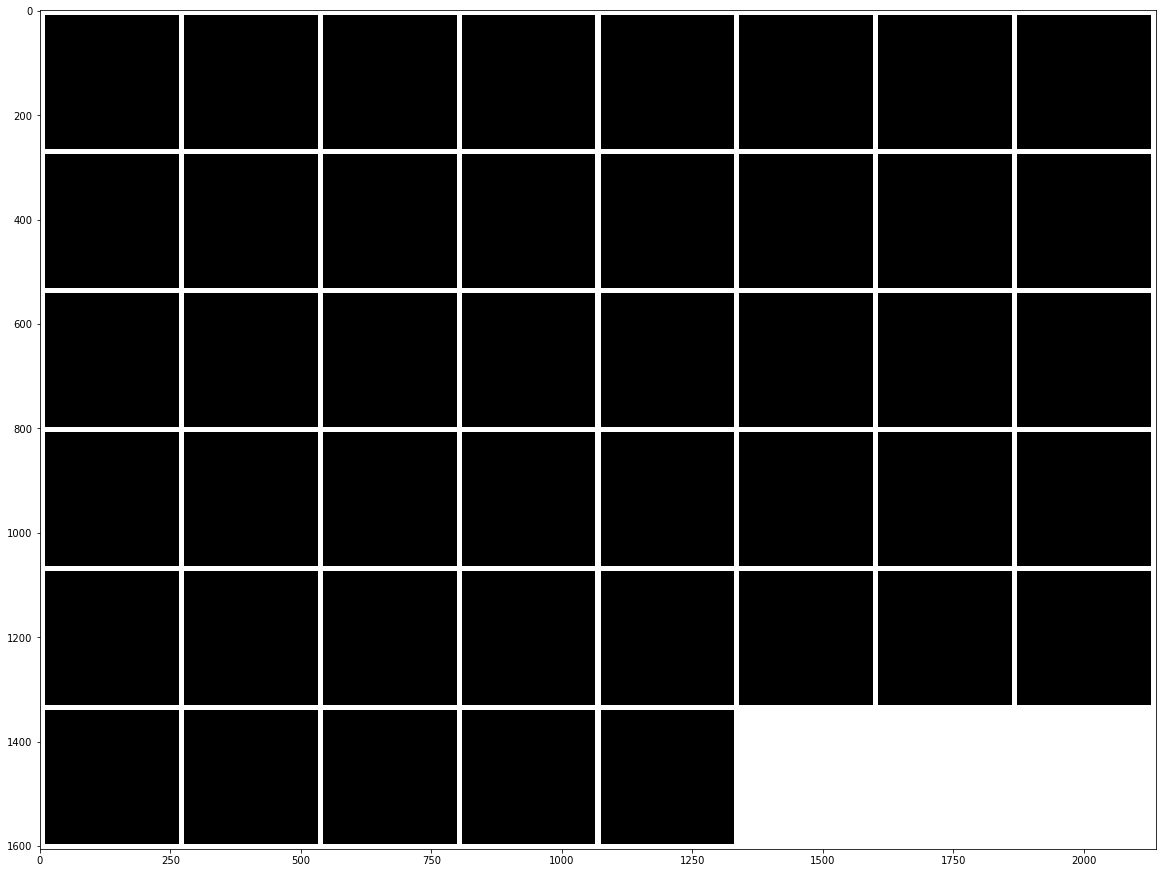

----------------------------------------------------------------------------------------------------
Prediction


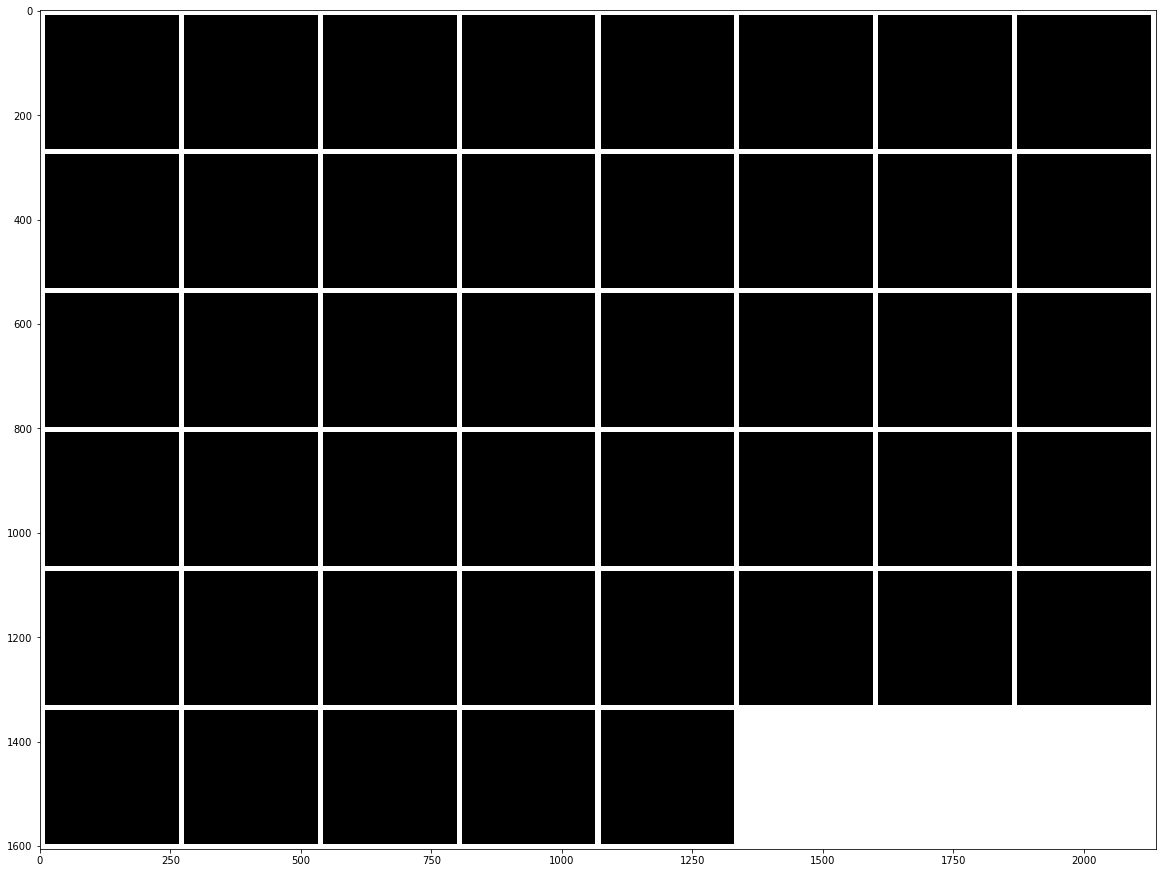

----------------------------------------------------------------------------------------------------
Ground Truth


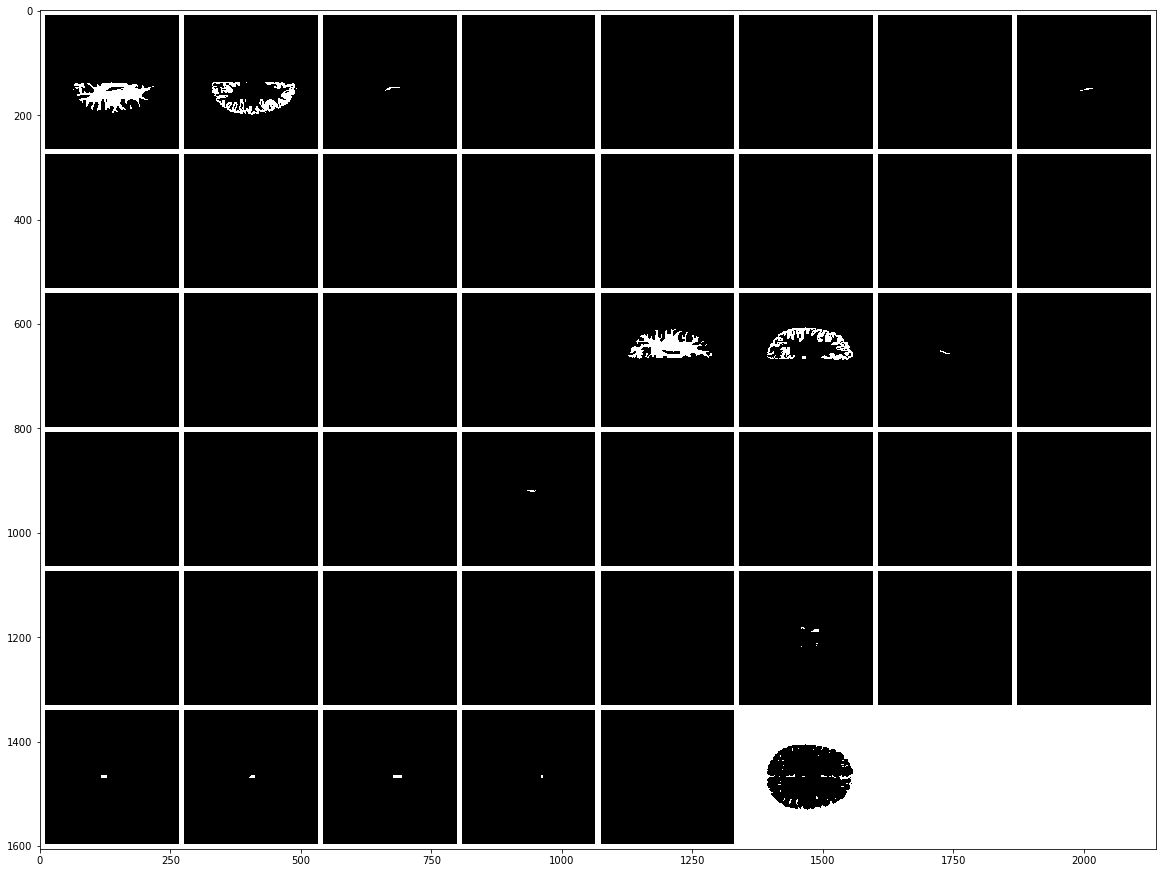

----------------------------------------------------------------------------------------------------
Prediction


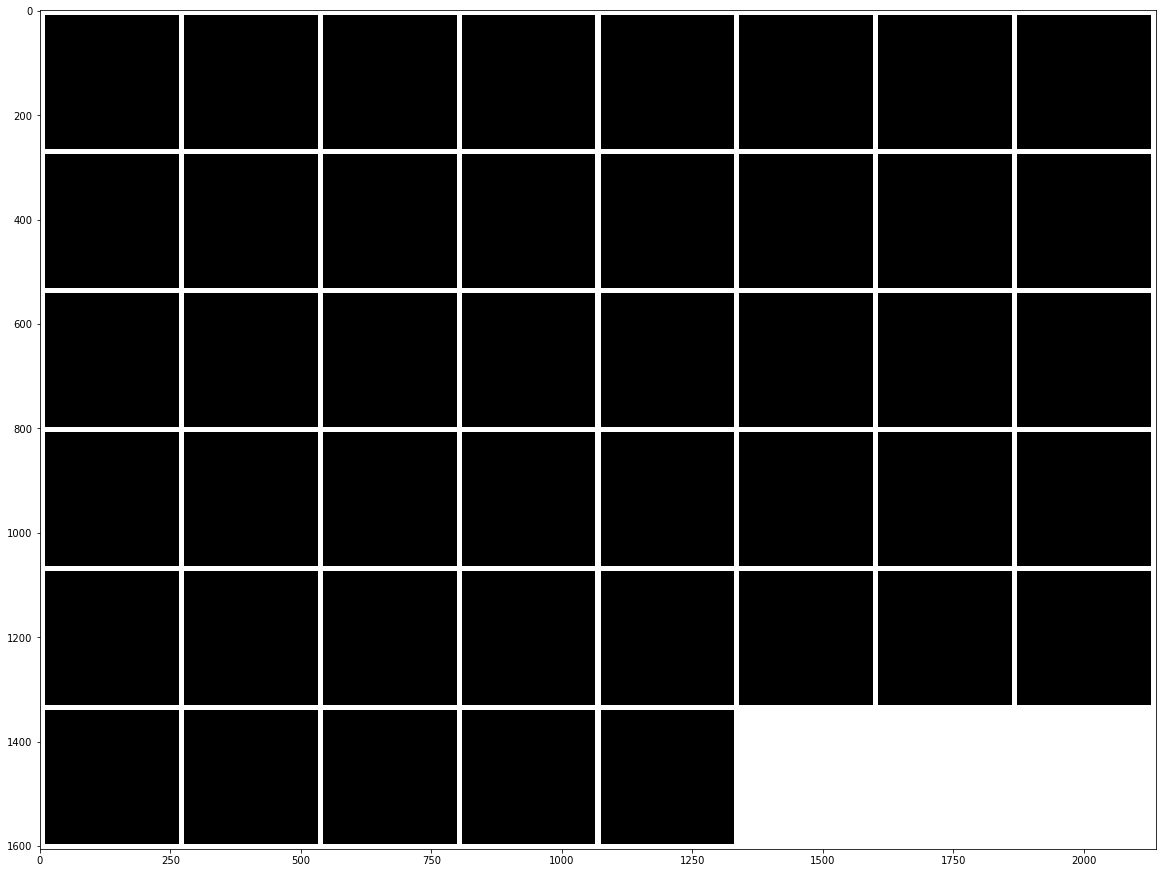

----------------------------------------------------------------------------------------------------
Ground Truth


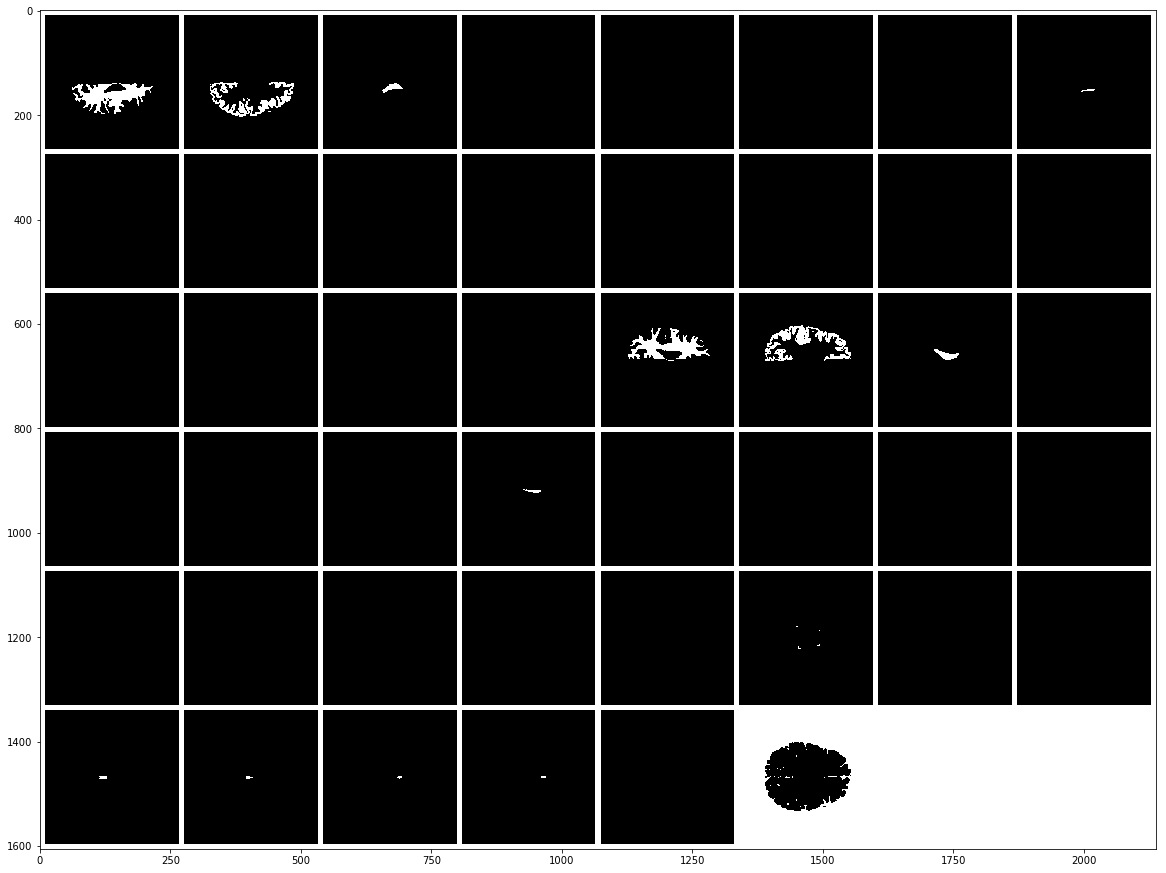

----------------------------------------------------------------------------------------------------
Prediction


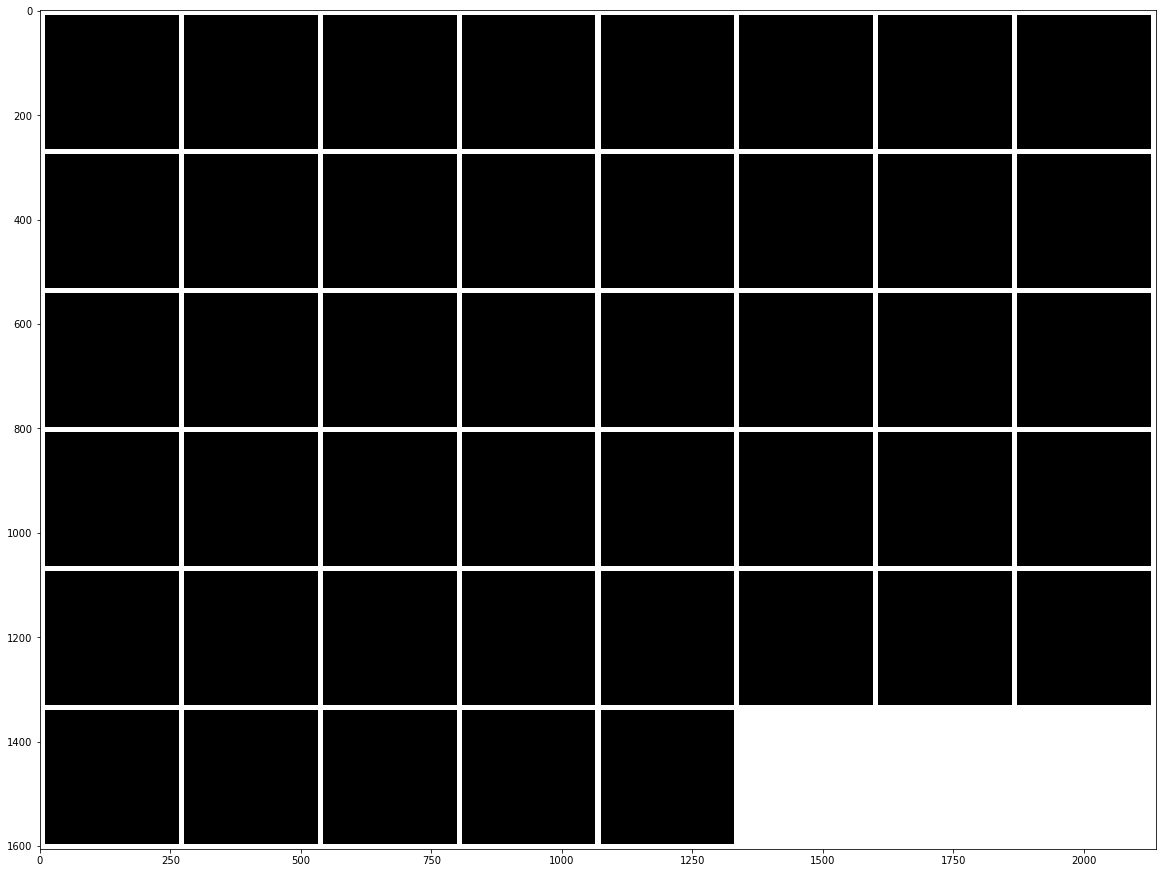

----------------------------------------------------------------------------------------------------
Ground Truth


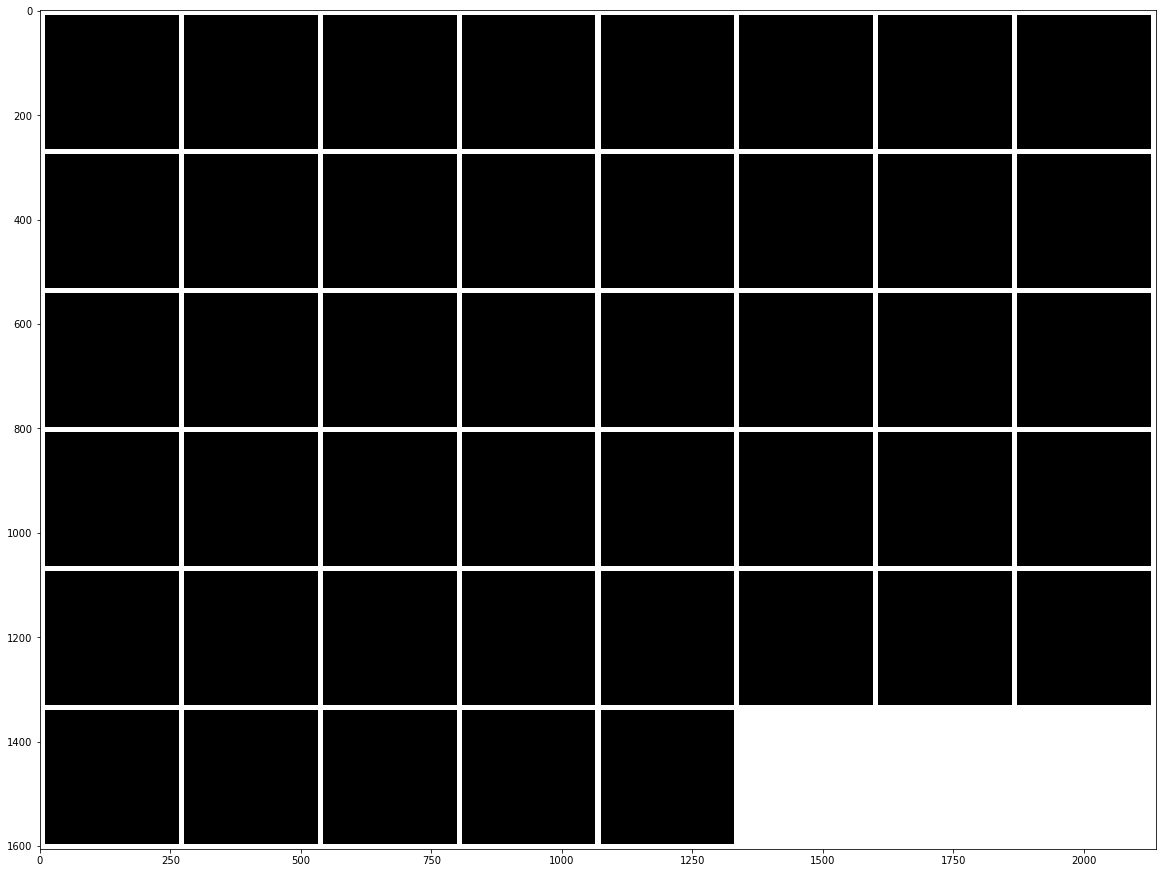

----------------------------------------------------------------------------------------------------
Prediction


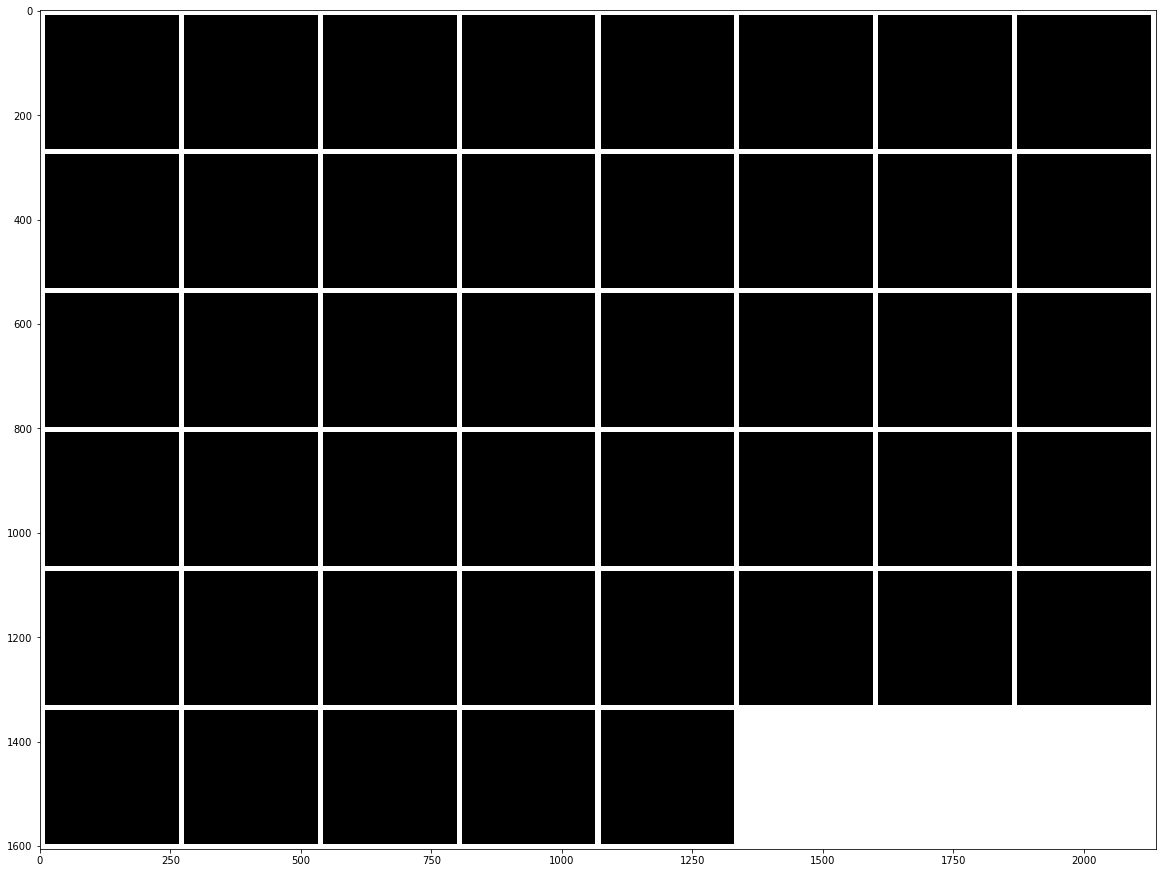

----------------------------------------------------------------------------------------------------
Ground Truth


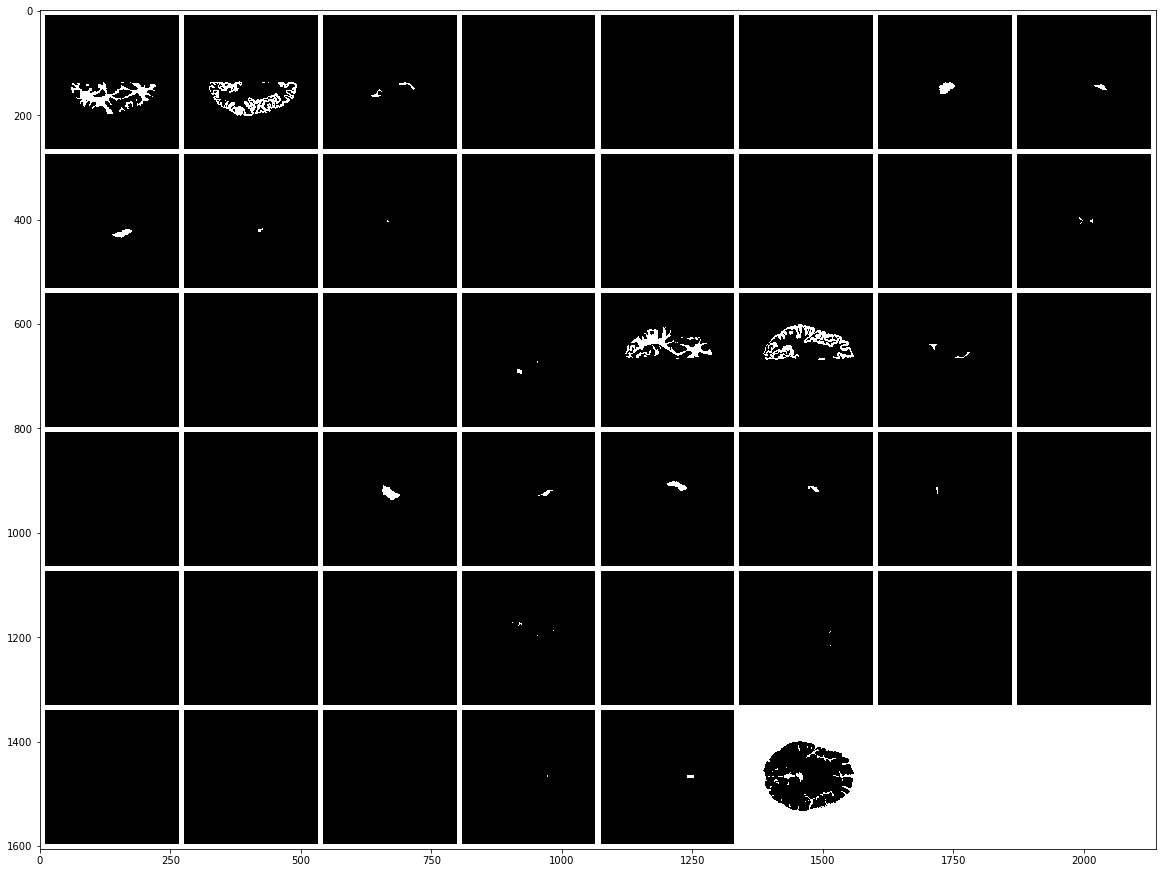

----------------------------------------------------------------------------------------------------
Prediction


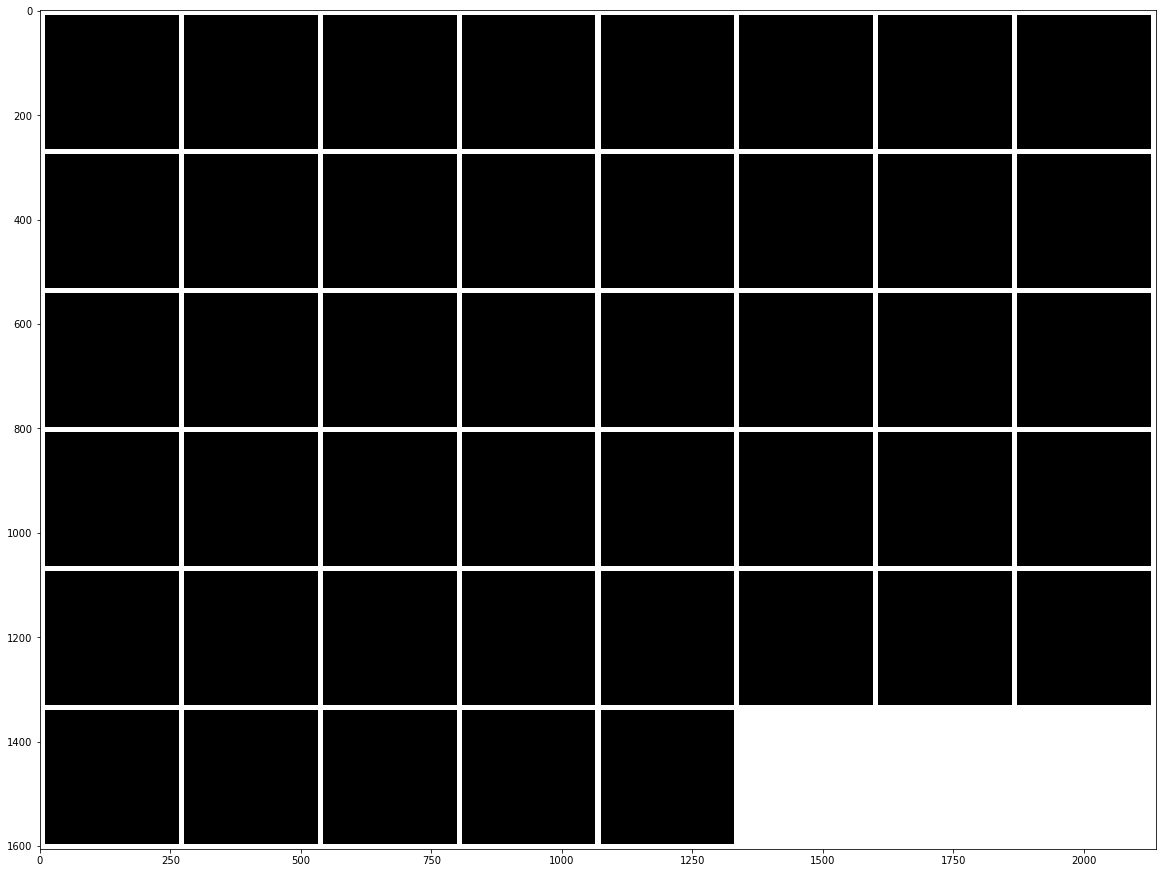

----------------------------------------------------------------------------------------------------
Ground Truth


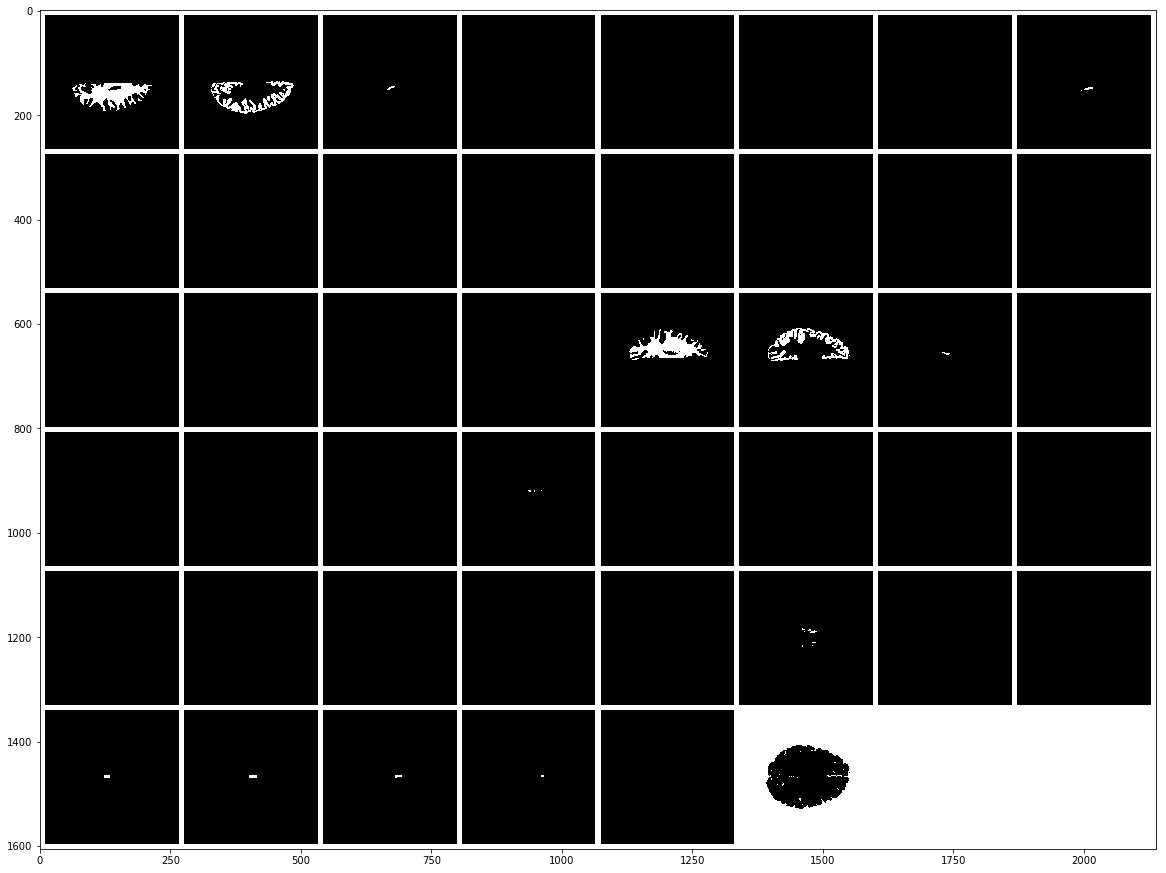

----------------------------------------------------------------------------------------------------
Prediction


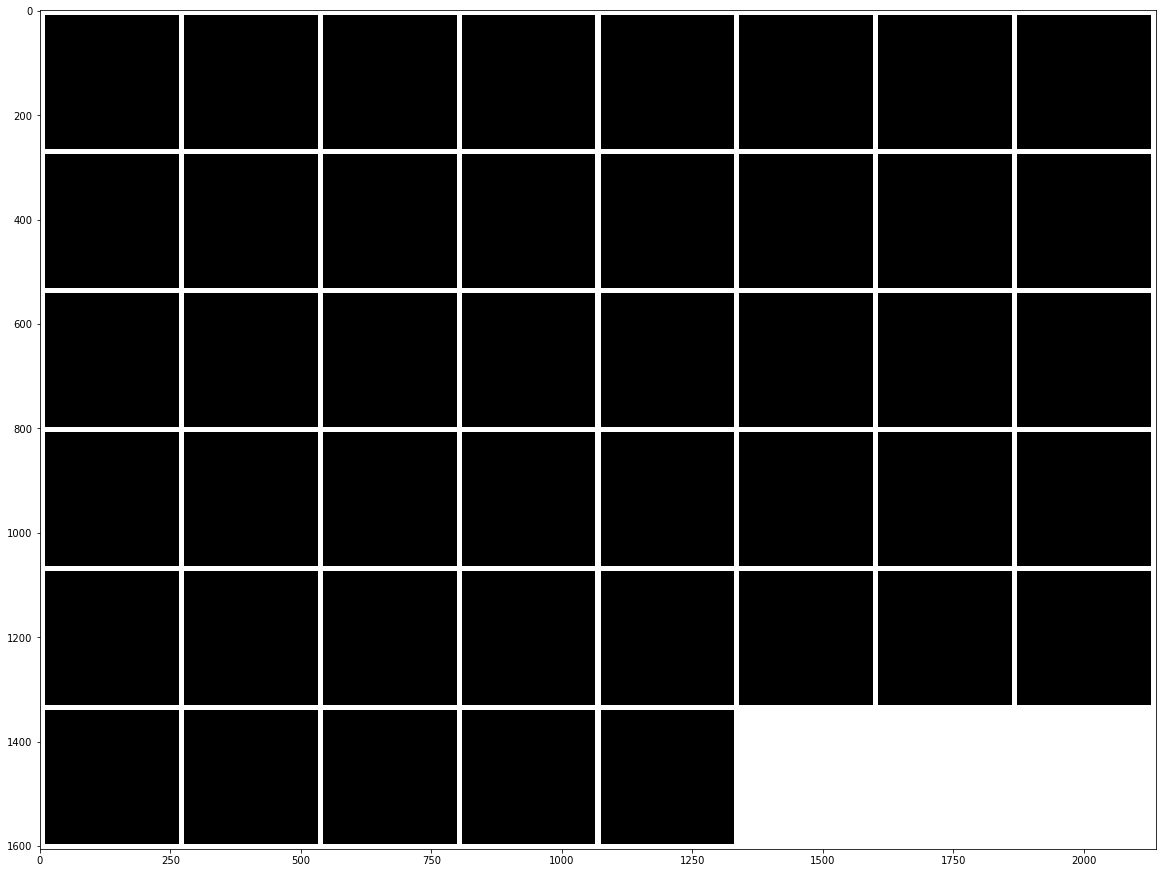

----------------------------------------------------------------------------------------------------
Ground Truth


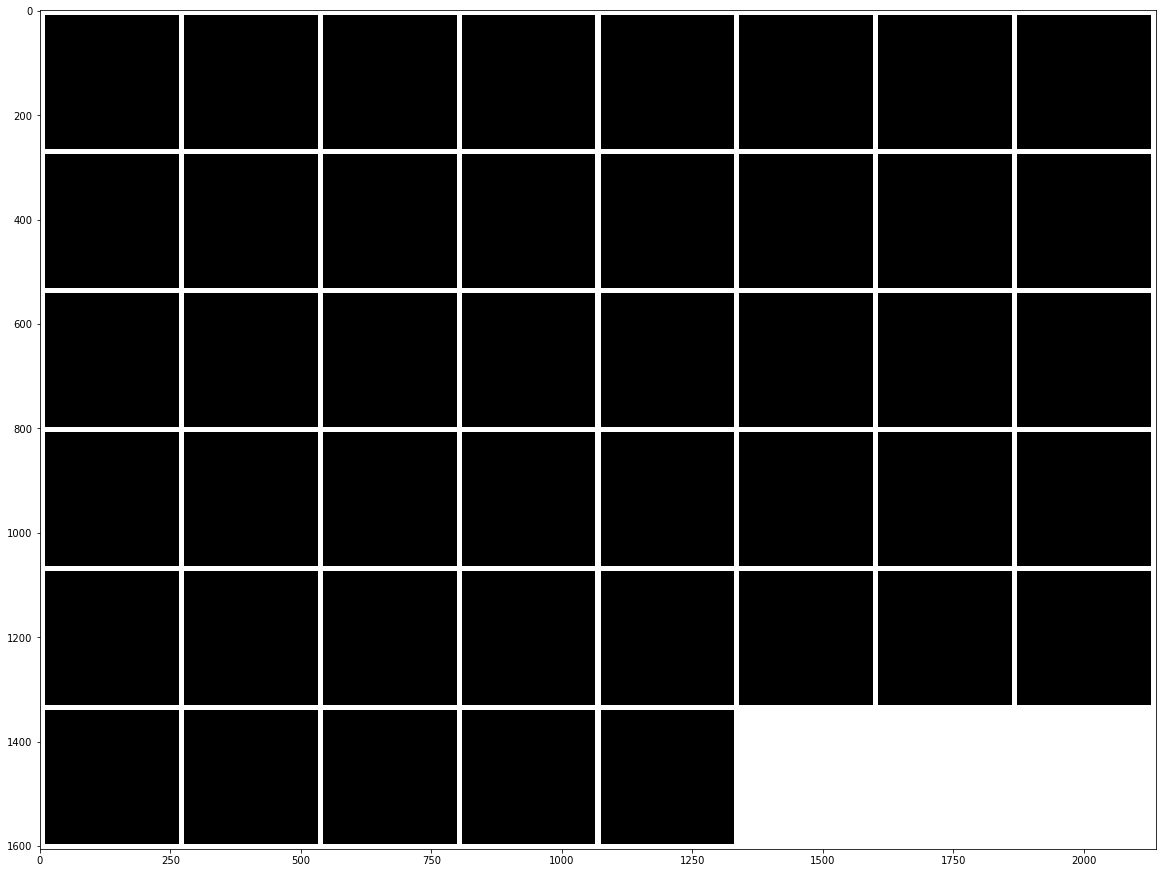

----------------------------------------------------------------------------------------------------
Prediction


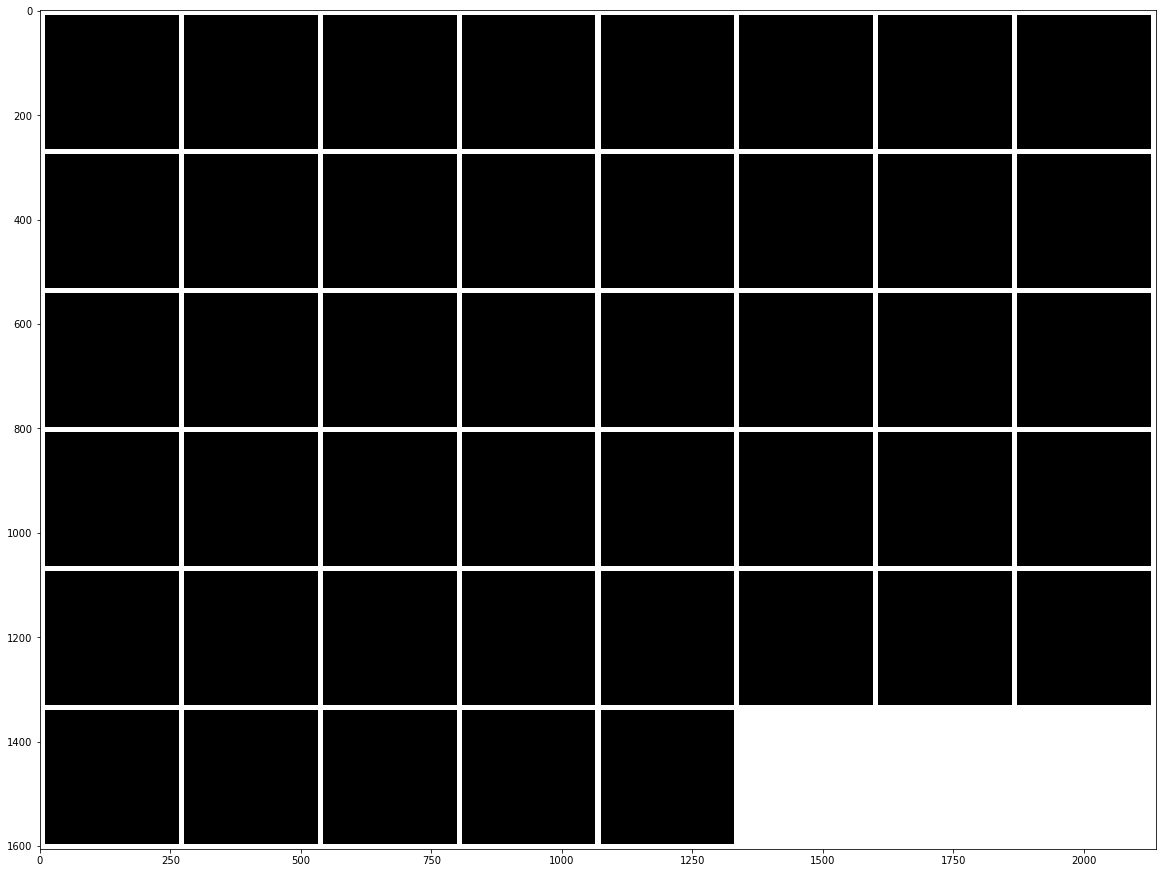

----------------------------------------------------------------------------------------------------
Ground Truth


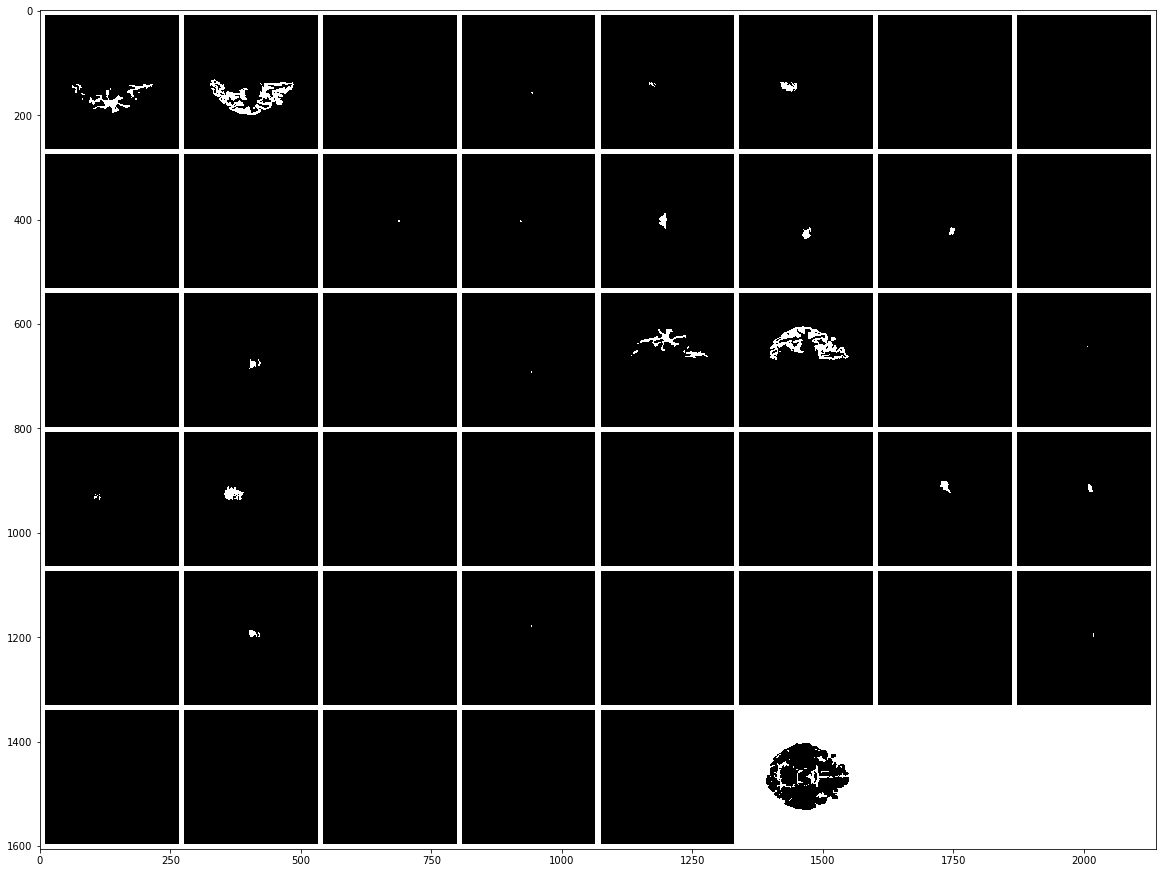

----------------------------------------------------------------------------------------------------
Prediction


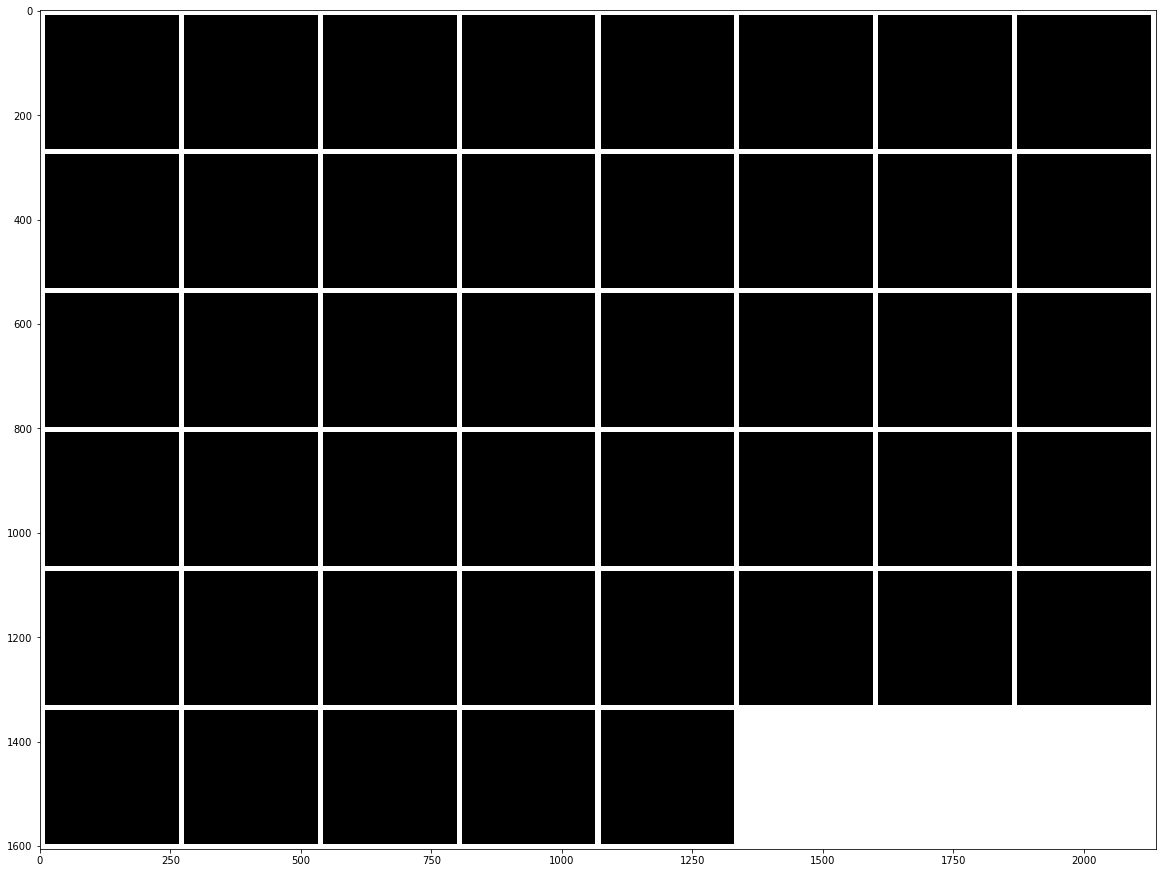

----------------------------------------------------------------------------------------------------
Ground Truth


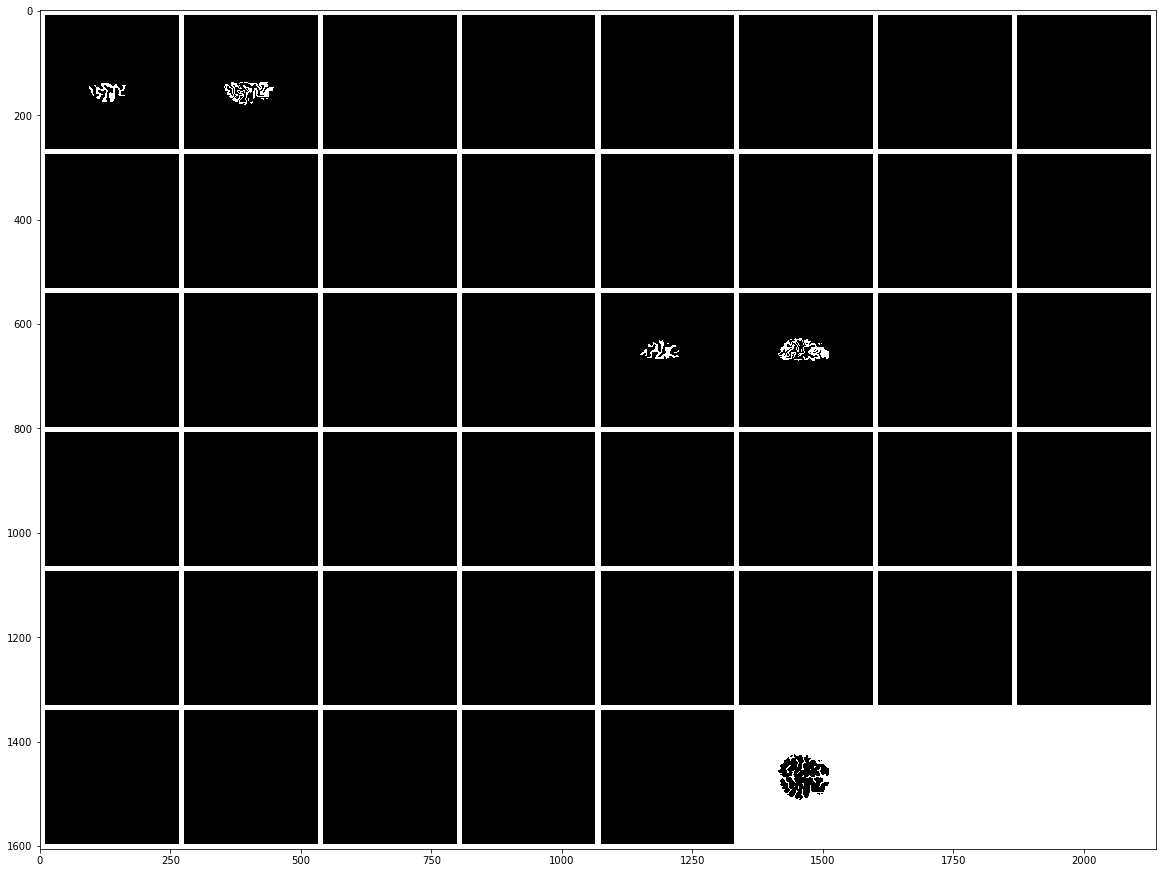

----------------------------------------------------------------------------------------------------
Prediction


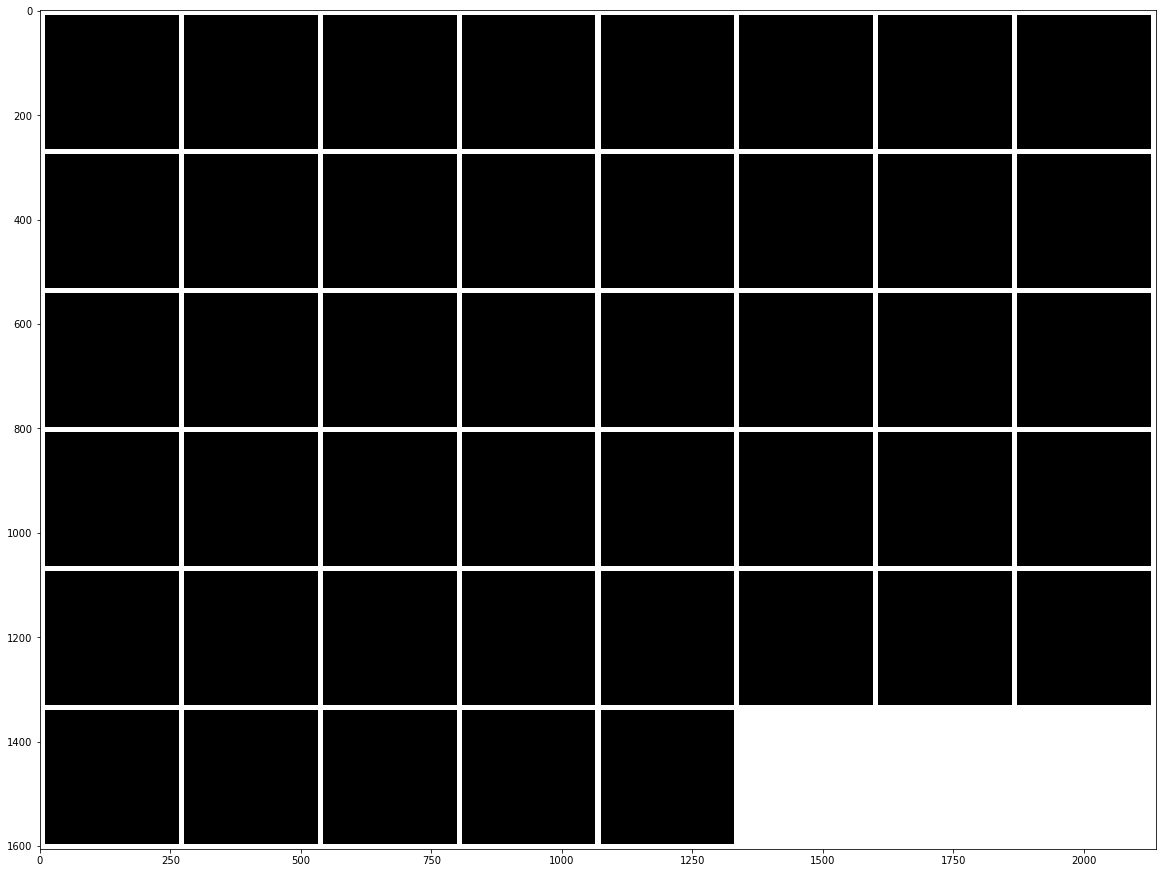

----------------------------------------------------------------------------------------------------
Ground Truth


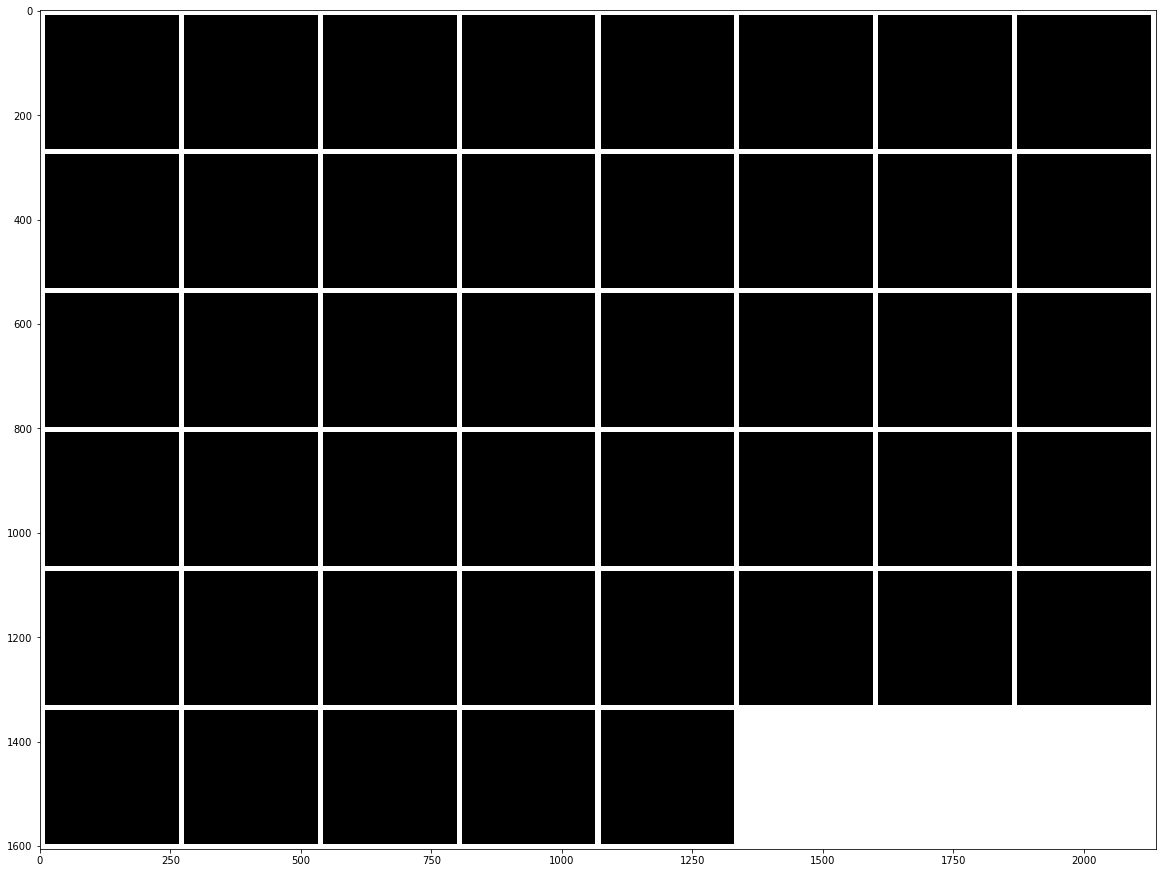

----------------------------------------------------------------------------------------------------
Prediction


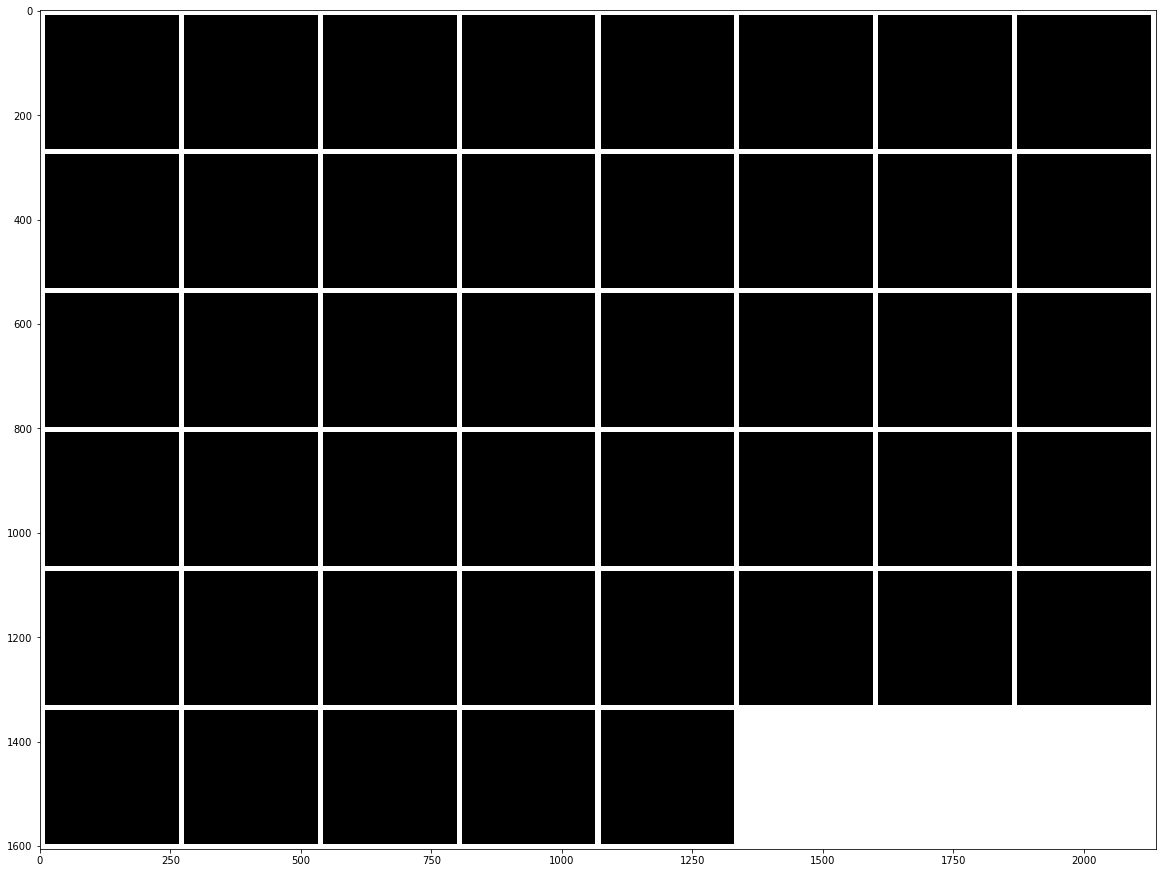

----------------------------------------------------------------------------------------------------
Ground Truth


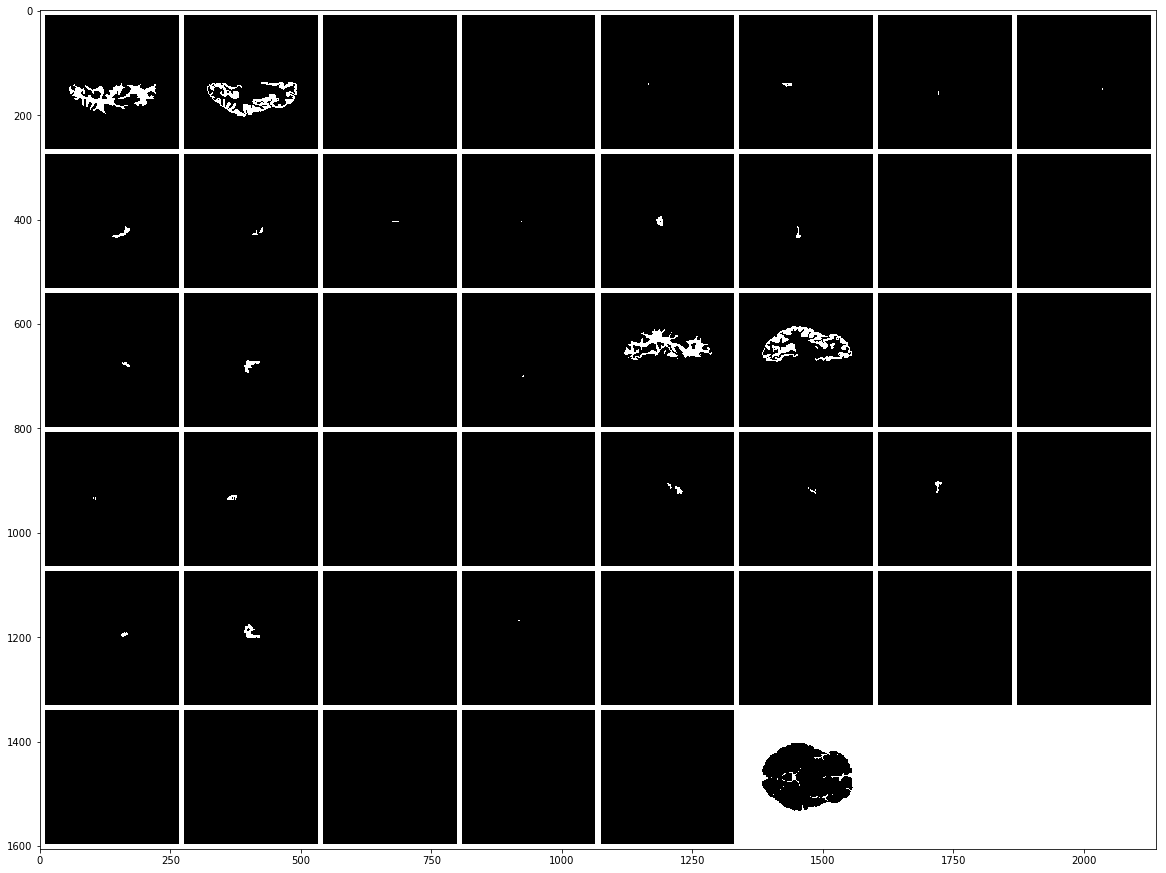

----------------------------------------------------------------------------------------------------
Prediction


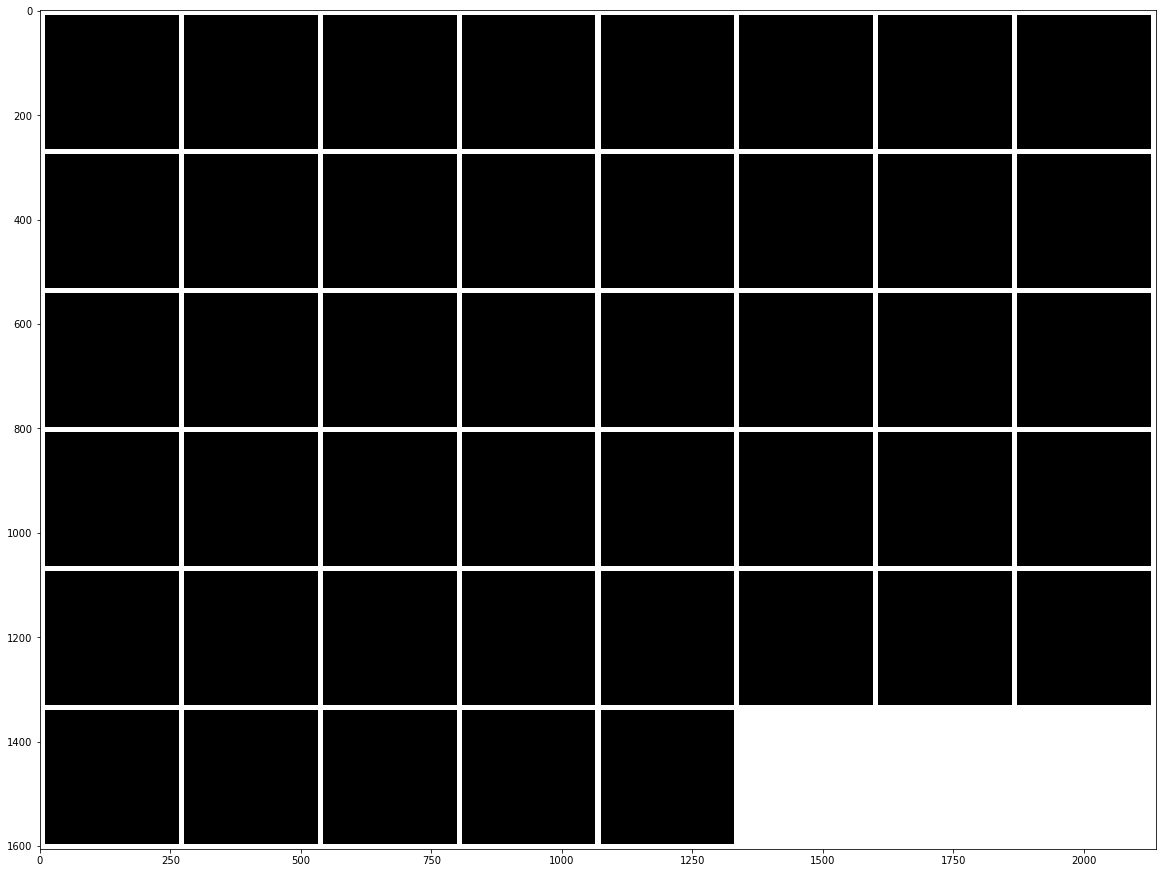

----------------------------------------------------------------------------------------------------
Ground Truth


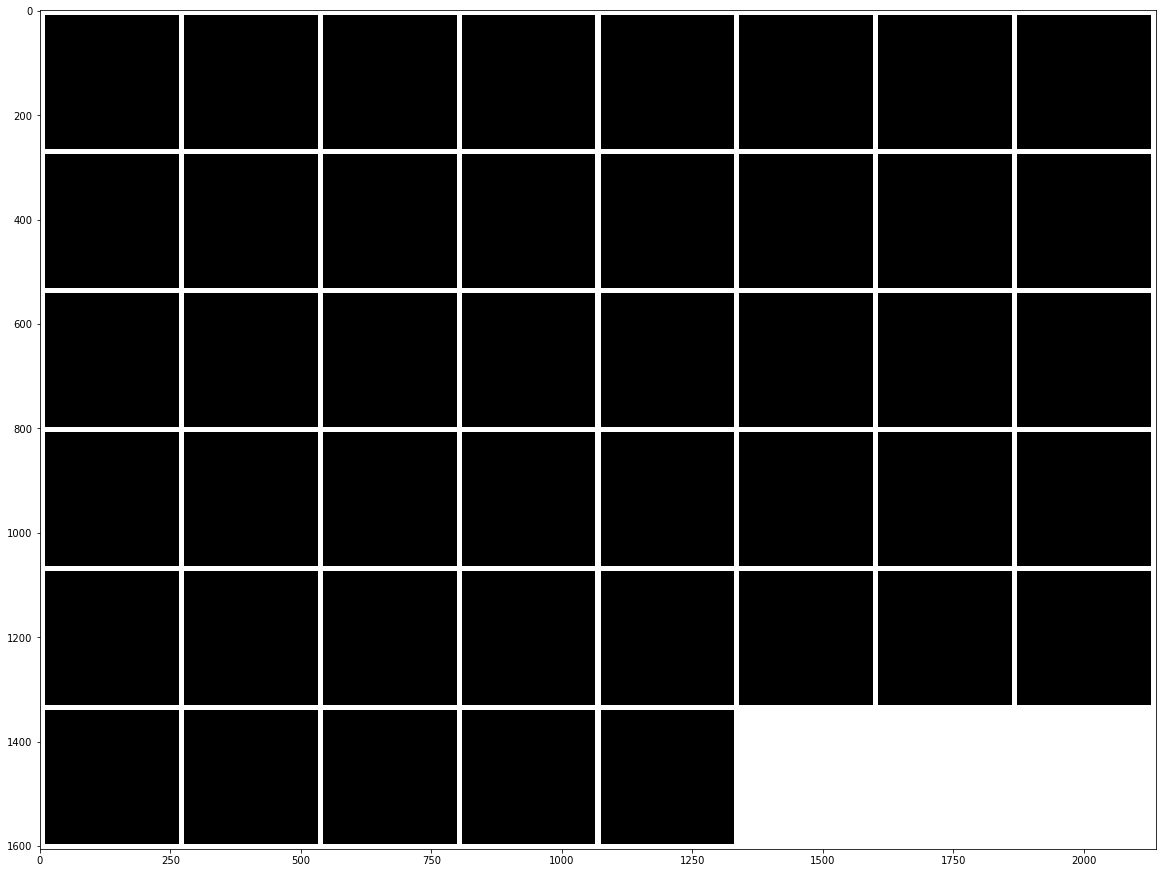

----------------------------------------------------------------------------------------------------
Prediction


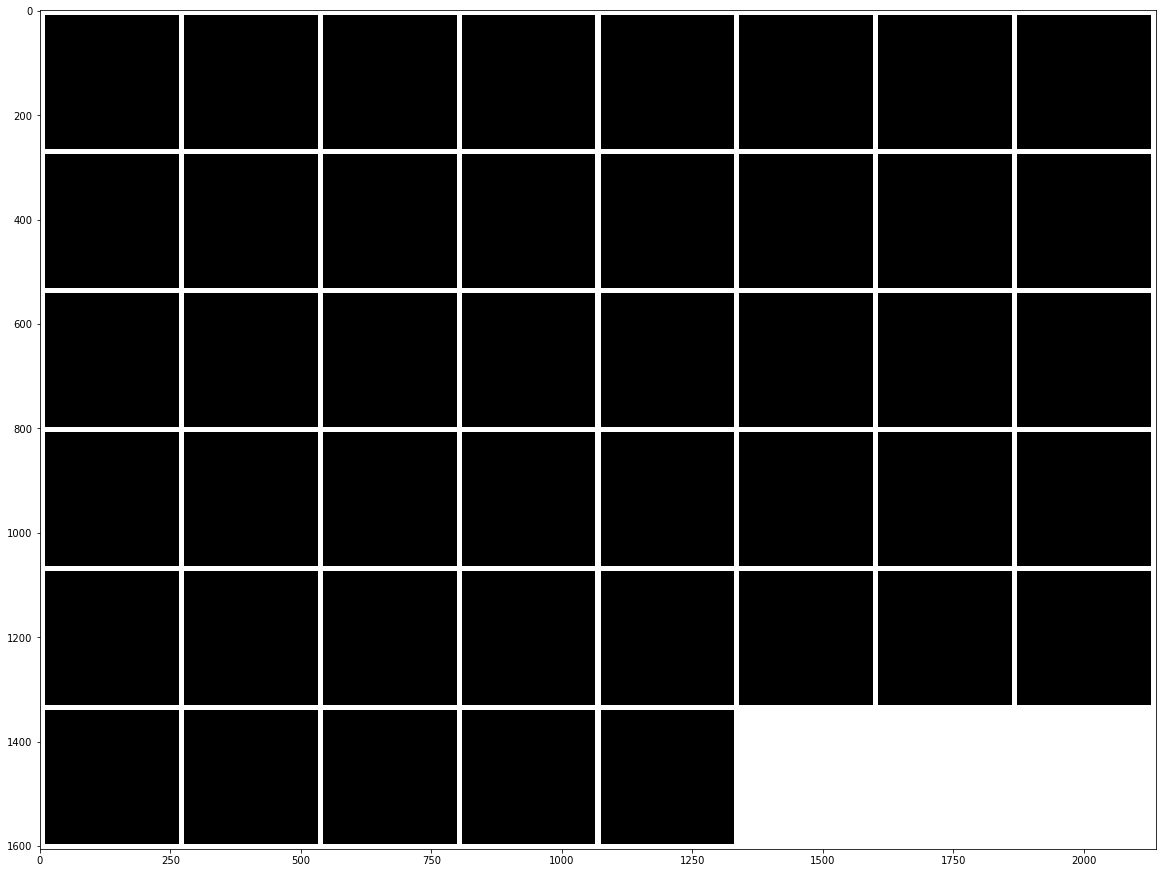

In [43]:
visualize_few()